In [1]:
# for files
import os
import zipfile
import PyPDF2

# for data
import numpy as np
import pandas as pd
import geopandas as gpd
import re
from math import isnan

# for viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#color_palette = ['#f94144', '#f3722c', '#f8961e', '#f9174f', '#90be6d', '#43aa8b', '#577590', '#173F5F']
rocket_palette = sns.color_palette("rocket", 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

## DATA SOURCES

For this project, the following sources found in the Test repo are used:

- NYC taxi data (Jan, Apr, July 2015): 
        https://storage.googleapis.com/hiring-test/data.zip
- Data dictionary of the NYC taxi data: 
        https://storage.googleapis.com/hiring-test/data_dictionary_trip_records_yellow.pdf
- ACS demographic and socio-economic data by census block group (the variables are self-explanatory):
        https://storage.googleapis.com/hiring-test/nyc_acs_demographics.csv
- NYC census block group geometries: 
        https://storage.googleapis.com/hiring-test/nyc_cbg_geoms.geojson

## OPENING FILES

Due to the lack of local space in my current linux setup, data is opened directly from the google storage

**----------------------------------------------------------------------------------------------**

In [3]:
NYC_TAXI_ZIP = 'https://storage.googleapis.com/hiring-test/data.zip'
NYC_TAXI_DICT = 'https://storage.googleapis.com/hiring-test/data_dictionary_trip_records_yellow.pdf'
CENSUS_ACS_DATA = 'https://storage.googleapis.com/hiring-test/nyc_acs_demographics.csv'
CENSUS_GEOM = 'https://storage.googleapis.com/hiring-test/nyc_cbg_geoms.geojson'

## 3
## ACS Demographic and socio-economic data by census block group

In [4]:
census_df = pd.read_csv(CENSUS_ACS_DATA)

### 3.1 

Let's have a look at the raw data ...

In [5]:
display(census_df.info())
print(f'Shape: \t\t {census_df.shape}\n')
display(census_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199630 entries, 0 to 199629
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     199630 non-null  int64  
 1   geoid          199630 non-null  int64  
 2   acs_demog_var  199630 non-null  object 
 3   value          199630 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.1+ MB


None

Shape: 		 (199630, 4)



Unnamed: 0         geoid                       acs_demog_var   value
0                0  360050001001                           total_pop  7080.0
1                1  360050001001               two_or_more_races_pop    41.0
2                2  360050001001       vacant_housing_units_for_rent     0.0
3                3  360050001001                      unemployed_pop     0.0
4                4  360050001001                           black_pop  3984.0
...            ...           ...                                 ...     ...
199625      199625  361190055004       vacant_housing_units_for_rent     0.0
199626      199626  361190055004         median_year_structure_built     0.0
199627      199627  361190055004                        hispanic_pop    72.0
199628      199628  361190055004  commuters_by_public_transportation   177.0
199629      199629  361190055004                      unemployed_pop    74.0

[199630 rows x 4 columns]

In [6]:
# Droping duplicated ID column
census_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
# Checking for unique values in columns
display(census_df['geoid'].value_counts())
display(census_df['acs_demog_var'].value_counts())

360810934023    33
360470273001    33
360811571022    33
360610007001    33
360471014001    33
                ..
360810219001    25
360810246001    25
360470960001    25
360470031003    25
360810613021    25
Name: geoid, Length: 6339, dtype: int64

vacant_housing_units_for_rent                                  6339
asian_pop                                                      6339
two_or_more_races_pop                                          6339
white_pop                                                      6339
households                                                     6339
pop_16_over                                                    6339
housing_units                                                  6339
black_pop                                                      6339
total_pop                                                      6339
families_with_young_children                                   6339
unemployed_pop                                                 6339
family_households                                              6339
married_households                                             6339
amerindian_pop                                                 6339
employed_pop                                    

For each geoid there are 33 demographic variables
It looks that there are some nulls in some of the variables

In [8]:
# Let's create a table with cols as 'acs_demog_var' and index as 'geoid'
census_tb = census_df.groupby(by = ['geoid', 'acs_demog_var']).mean()
census_tb = census_tb.unstack(level = -1)

census_tb.columns = census_tb.columns.droplevel()
census_tb.reset_index(inplace=True)
census_tb.head()

acs_demog_var         geoid  aggregate_travel_time_to_work  amerindian_pop  \
0              360050001001                            NaN            25.0   
1              360050002001                            NaN             0.0   
2              360050002002                            NaN             0.0   
3              360050002003                            NaN             0.0   
4              360050004001                            NaN             0.0   

acs_demog_var  asian_pop  black_pop  commuters_16_over  \
0                  125.0     3984.0                0.0   
1                    0.0      468.0              608.0   
2                    0.0      238.0              579.0   
3                  104.0      202.0              382.0   
4                   24.0       24.0              213.0   

acs_demog_var  commuters_by_public_transportation  employed_pop  \
0                                             0.0           0.0   
1                                           271.0         608.0   
2                                           161.0         588.0   
3                                           108.0         382.0   
4                                            69.0         259.0   

acs_demog_var  families_with_young_children  family_households  ...  \
0                                       0.0                0.0  ...   
1                                      63.0              356.0  ...   
2                                      96.0              363.0  ...   
3                                      33.0              239.0  ...   
4                                       0.0              136.0  ...   

acs_demog_var  other_race_pop  owner_occupied_housing_units_median_value  \
0                        38.0                                        NaN   
1                         0.0                                   384200.0   
2                        86.0                                   415300.0   
3                         0.0                                   374700.0   
4                         0.0                                   363900.0   

acs_demog_var  pop_16_over  \
0                   7080.0   
1                   1543.0   
2                   1423.0   
3                    718.0   
4                    417.0   

acs_demog_var  renter_occupied_housing_units_paying_cash_median_gross_rent  \
0                                                            NaN             
1                                                         1793.0             
2                                                         1358.0             
3                                                         1677.0             
4                                                         1375.0             

acs_demog_var  total_pop  two_or_more_races_pop  unemployed_pop  \
0                 7080.0                   41.0             0.0   
1                 1919.0                    0.0           168.0   
2                 1703.0                    0.0           118.0   
3                  920.0                    0.0             9.0   
4                  468.0                    0.0             0.0   

acs_demog_var  vacant_housing_units  vacant_housing_units_for_rent  white_pop  
0                               0.0                            0.0      538.0  
1                              30.0                            0.0       13.0  
2                              71.0                           15.0       52.0  
3                              57.0                            0.0       12.0  
4                              15.0                           15.0        0.0  

[5 rows x 34 columns]

## PT 3.2
## MISSING VALUES

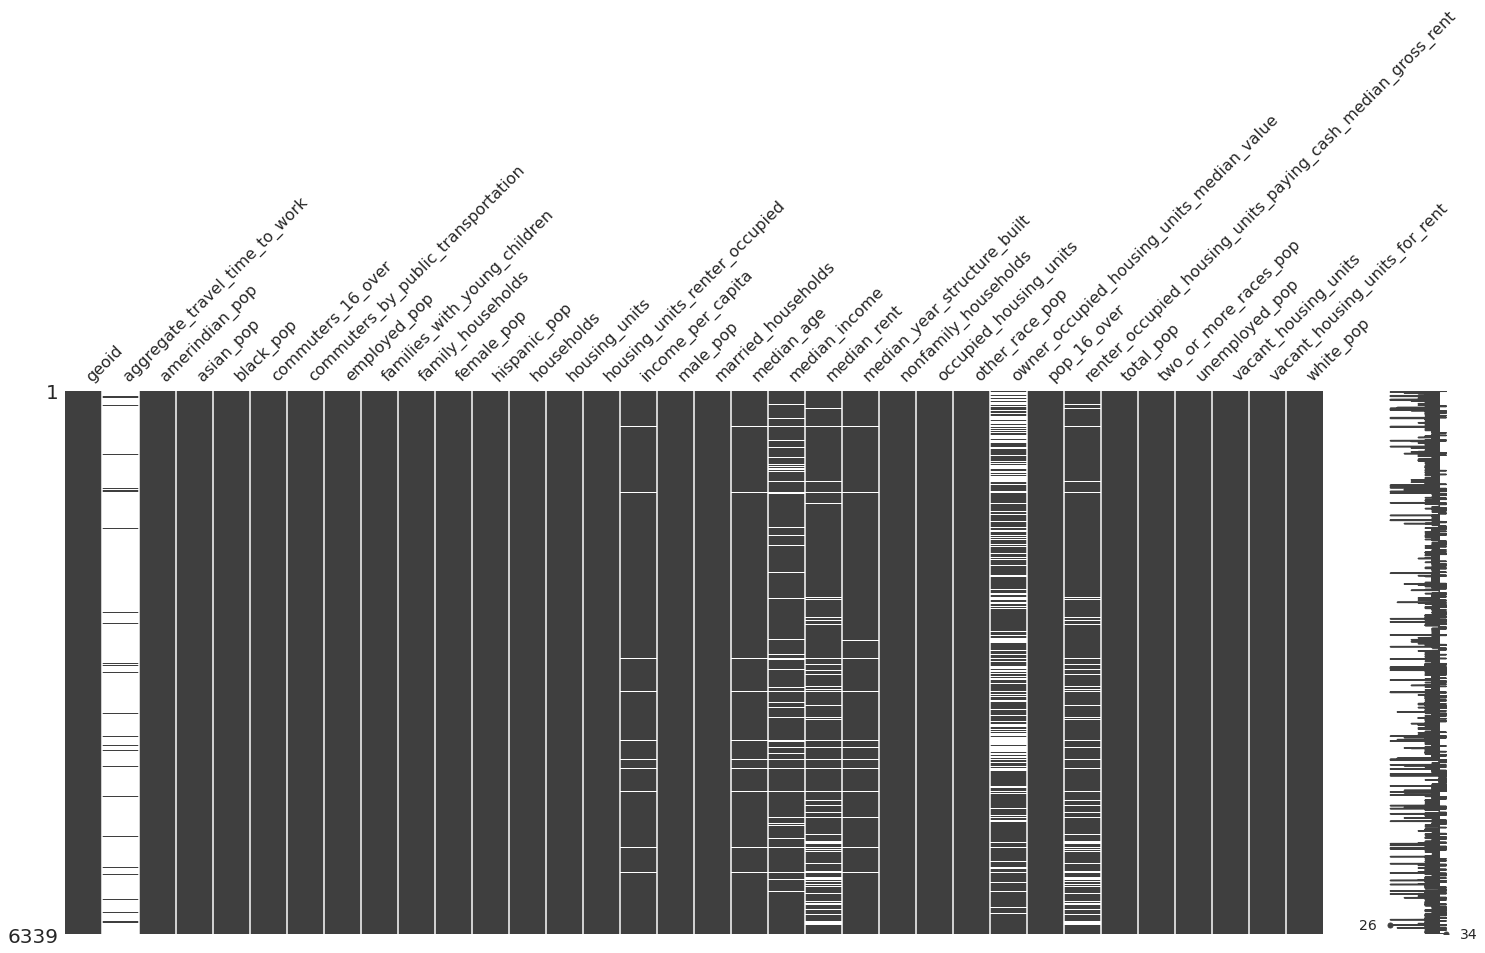

In [9]:
# let's have a look at the missing values
import missingno as msno

msno.matrix(census_tb)
plt.show()

**INSIGHTS FROM NULL DATA VIZ**

- Most of aggregate_travel_time_to_work is mostly NaN
- income_per_capita == median_age == median_year_structure_built in NaN values
- Lost of NaNs in owner_occupied_housing_units_median_value
- Other cols with some nulls are "median_income", "median_rent" and "renter_occupied_housing_units_paying_Cash_median_gross_rent"

In [10]:
census_tb.info()

# All numeric data
# geoid is discrete
# all cols from 'acs_demog_var' are continuousd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 34 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   geoid                                                        6339 non-null   int64  
 1   aggregate_travel_time_to_work                                362 non-null    float64
 2   amerindian_pop                                               6339 non-null   float64
 3   asian_pop                                                    6339 non-null   float64
 4   black_pop                                                    6339 non-null   float64
 5   commuters_16_over                                            6339 non-null   float64
 6   commuters_by_public_transportation                           6339 non-null   float64
 7   employed_pop                                                 6339 non-null   f

In [11]:
census_tb.describe()

acs_demog_var         geoid  aggregate_travel_time_to_work  amerindian_pop  \
count          6.339000e+03                     362.000000     6339.000000   
mean           3.605324e+11                   34616.422652        2.380186   
std            2.661184e+08                   20381.770030       13.583396   
min            3.600500e+11                    6450.000000        0.000000   
25%            3.604702e+11                   21785.000000        0.000000   
50%            3.604712e+11                   30877.500000        0.000000   
75%            3.608103e+11                   40933.750000        0.000000   
max            3.611901e+11                  195980.000000      274.000000   

acs_demog_var    asian_pop    black_pop  commuters_16_over  \
count          6339.000000  6339.000000        6339.000000   
mean            185.575170   295.618394         602.898880   
std             285.281508   436.053112         336.115082   
min               0.000000     0.000000           0.000000   
25%              10.000000     7.000000         397.000000   
50%              72.000000    79.000000         552.000000   
75%             237.500000   451.000000         751.500000   
max            3960.000000  4744.000000        6483.000000   

acs_demog_var  commuters_by_public_transportation  employed_pop  \
count                                 6339.000000   6339.000000   
mean                                   352.085029    644.844613   
std                                    248.154204    356.828817   
min                                      0.000000      0.000000   
25%                                    191.000000    425.000000   
50%                                    310.000000    588.000000   
75%                                    463.000000    800.000000   
max                                   4849.000000   6767.000000   

acs_demog_var  families_with_young_children  family_households  ...  \
count                           6339.000000        6339.000000  ...   
mean                              98.536362         300.488405  ...   
std                               87.249059         158.296530  ...   
min                                0.000000           0.000000  ...   
25%                               39.000000         200.000000  ...   
50%                               79.000000         278.000000  ...   
75%                              136.000000         374.000000  ...   
max                             1030.000000        2250.000000  ...   

acs_demog_var  other_race_pop  owner_occupied_housing_units_median_value  \
count             6339.000000                               4.556000e+03   
mean                11.458116                               6.872881e+05   
std                 43.207546                               3.830040e+05   
min                  0.000000                               9.999000e+03   
25%                  0.000000                               4.430000e+05   
50%                  0.000000                               5.981500e+05   
75%                  0.000000                               8.288000e+05   
max                721.000000                               2.000001e+06   

acs_demog_var  pop_16_over  \
count          6339.000000   
mean           1091.115160   
std             539.026034   
min               0.000000   
25%             747.000000   
50%            1013.000000   
75%            1332.000000   
max            7881.000000   

acs_demog_var  renter_occupied_housing_units_paying_cash_median_gross_rent  \
count                                                5807.000000             
mean                                                 1523.152574             
std                                                   535.556652             
min                                                   229.000000             
25%                                                  1232.000000             
50%                                                  1442.000000      

## PT 3.3
## DISTRIBUTIONS AND RELATIONSHIPS BETWEEN COLUMNS

Due to the large range of columns, they are separated into themes:

- Population information
- Housing information
- Median information
- Other columns that do not fall into those three categories

### 3.3.1
### POPULATION INSIGHTS

In [12]:
# SEARCHING FOR THOSE COLUMNS
pop_cols = [col for col in census_tb.columns if len(re.findall('pop', col))]

for col in pop_cols:
    fltr = census_tb[col] != 0
    print(f"Num of elements:  {census_tb[fltr].shape[0]}\t\t Num.of unique elements:  {len(census_tb[col].unique())} \t\t{col}\t\v")

Num of elements:  416		 Num.of unique elements:  111 		amerindian_pop	
Num of elements:  4961		 Num.of unique elements:  943 		asian_pop	
Num of elements:  4958		 Num.of unique elements:  1294 		black_pop	
Num of elements:  6265		 Num.of unique elements:  1357 		employed_pop	
Num of elements:  6270		 Num.of unique elements:  1398 		female_pop	
Num of elements:  6028		 Num.of unique elements:  1383 		hispanic_pop	
Num of elements:  6273		 Num.of unique elements:  1309 		male_pop	
Num of elements:  1332		 Num.of unique elements:  223 		other_race_pop	
Num of elements:  6277		 Num.of unique elements:  1844 		pop_16_over	
Num of elements:  6277		 Num.of unique elements:  2155 		total_pop	
Num of elements:  3541		 Num.of unique elements:  240 		two_or_more_races_pop	
Num of elements:  5504		 Num.of unique elements:  267 		unemployed_pop	
Num of elements:  5667		 Num.of unique elements:  1475 		white_pop	


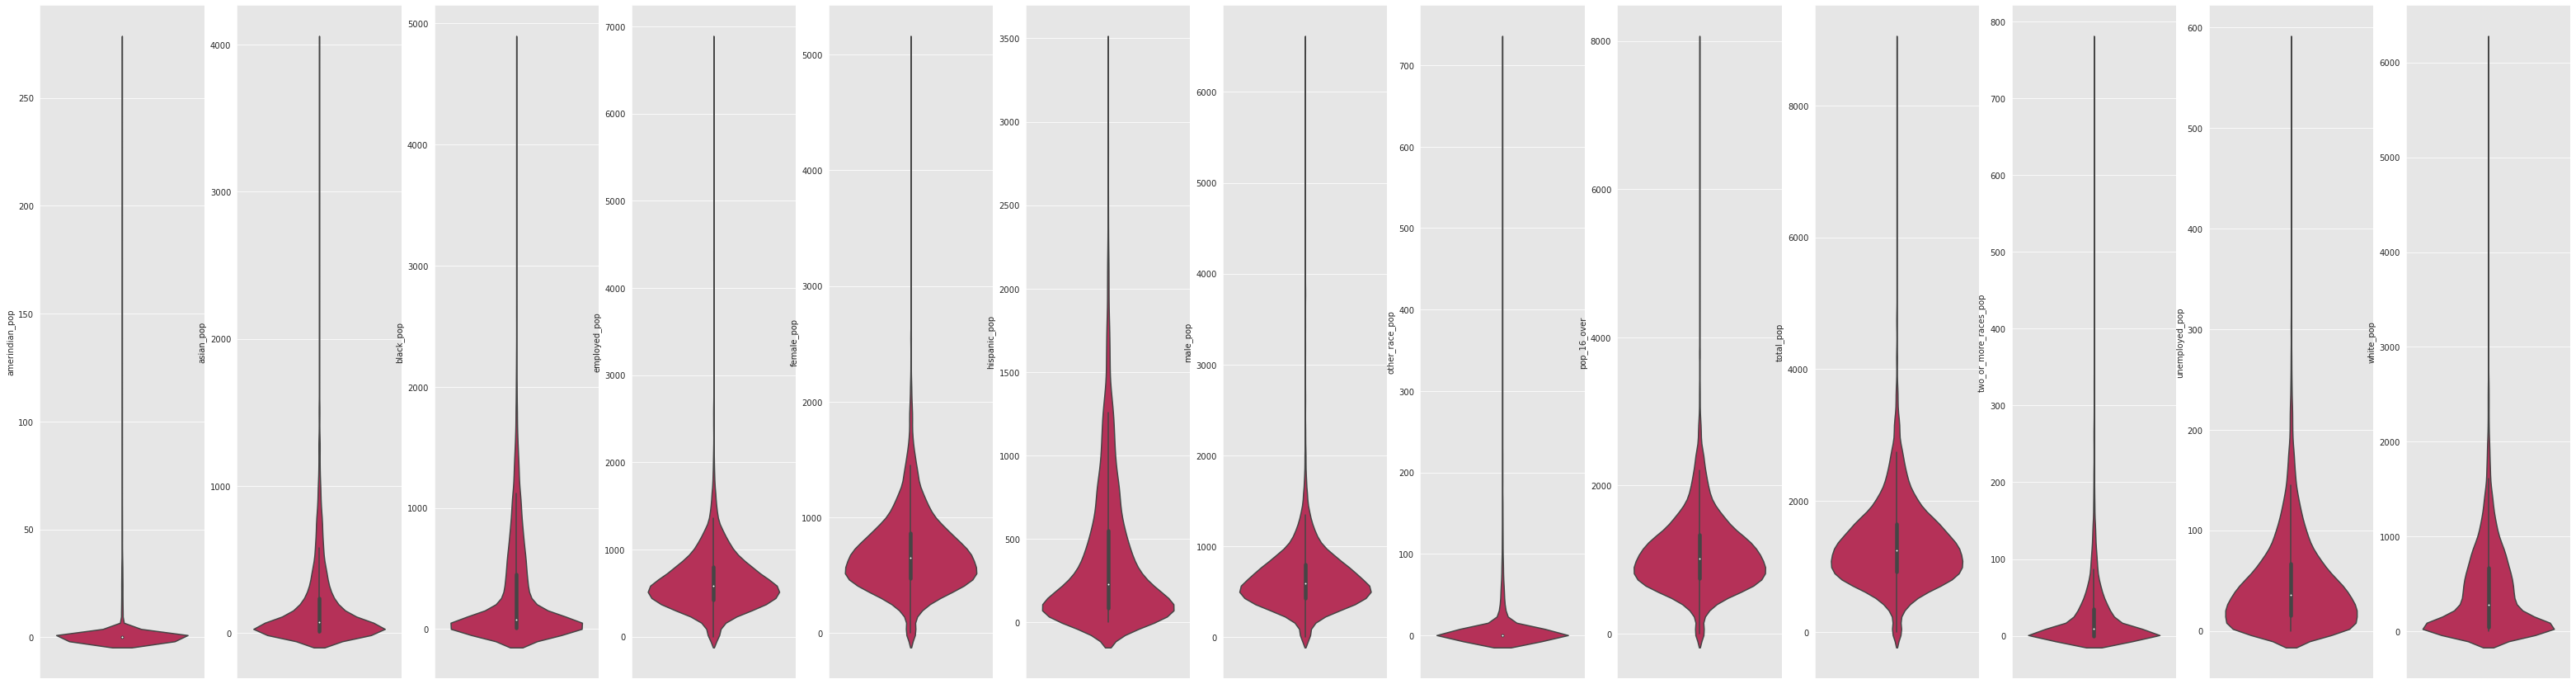

In [13]:
# DISTRIBUTION IN POPULATION COLUMNS
pop_cols = [col for col in census_tb.columns if len(re.findall('pop', col))]

fig, ax = plt.subplots(ncols = len(pop_cols), nrows = 1, figsize = (55,15))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(pop_cols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[2])

plt.show()

In [14]:
# Aggrupation of data taking into account distributions

pop_gr_1 = ['amerindian_pop', 'other_race_pop']                                   
pop_gr_2 = ['two_or_more_races_pop', 'asian_pop']                                 
pop_gr_3 = ['black_pop']                                                          
pop_gr_4 = ['total_pop', 'male_pop', 'female_pop', 'pop_16_over', 'employed_pop'] 
pop_gr_5 = ['hispanic_pop', 'unemployed_pop']
pop_gr_6 = ['white_pop']

# except for pop_gr_4 most of the data has a LOG-NORMAL DISTRIBUTION

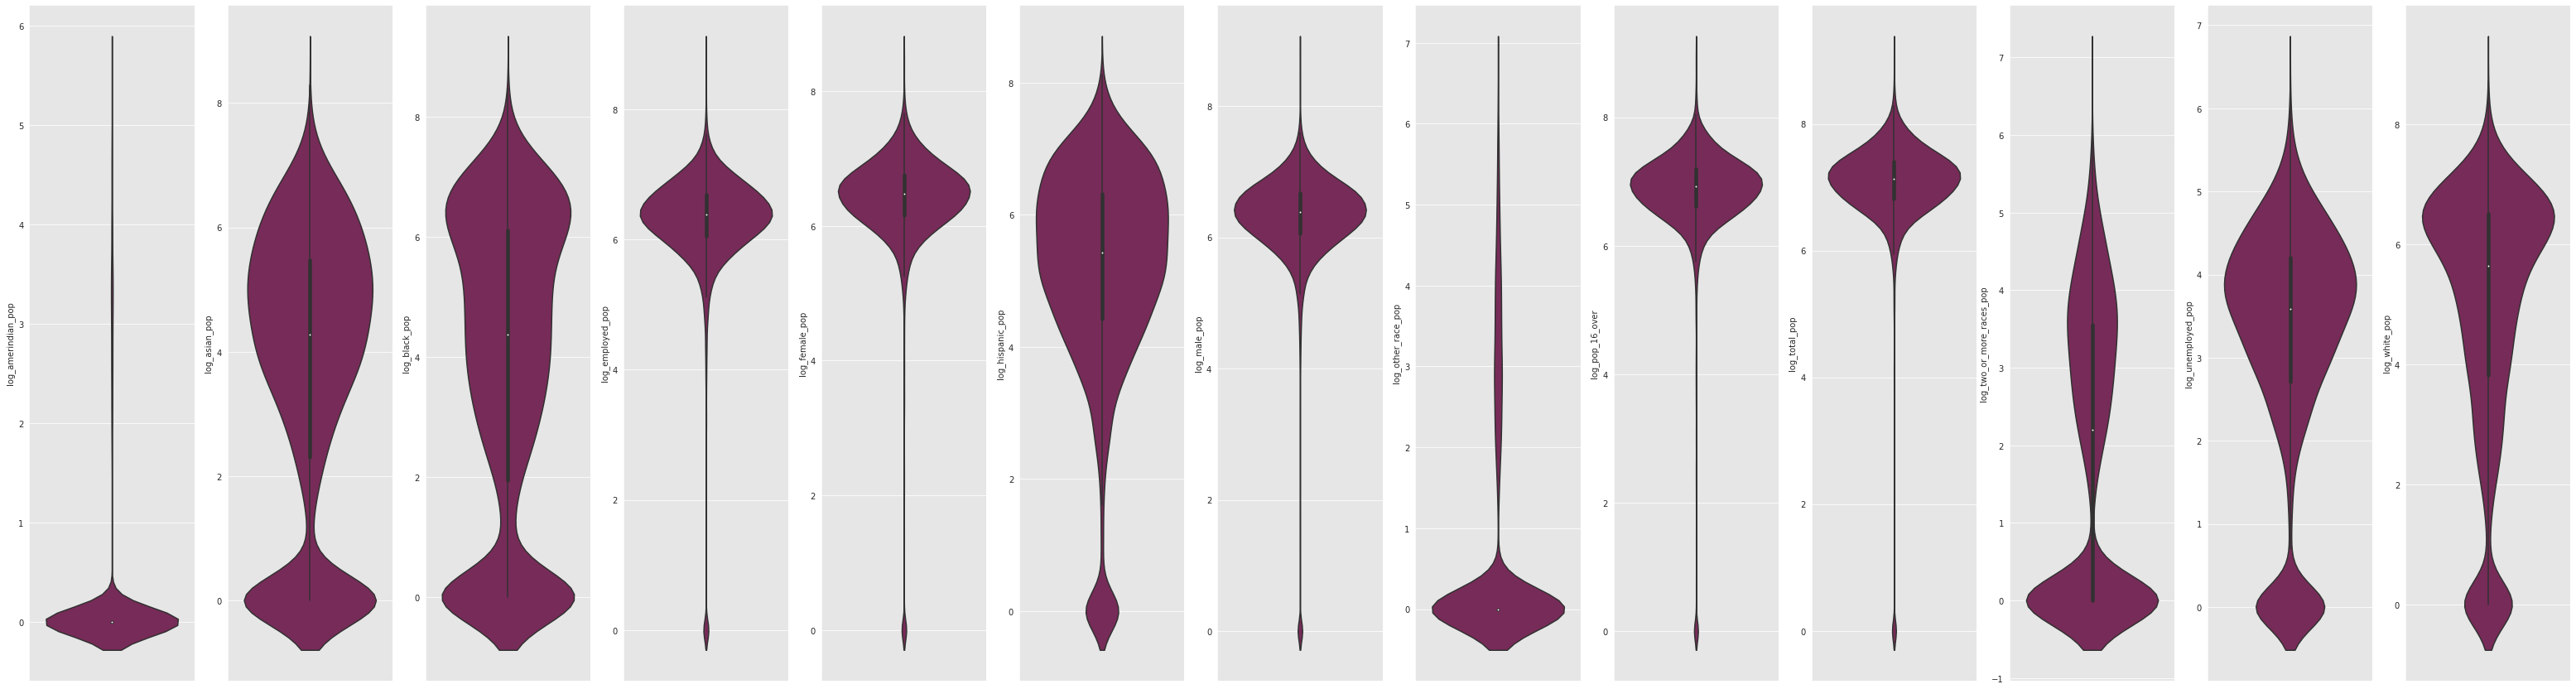

In [15]:
log_pop_cols = []
for col in pop_cols:
    census_tb[f"log_{col}"] = census_tb.apply(lambda x: np.log(x[col]) if x[col] != 0 else x[col], axis = 1)
    log_pop_cols.append(f"log_{col}")

fig, ax = plt.subplots(ncols = len(log_pop_cols), nrows = 1, figsize = (55,15))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(log_pop_cols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[1])

plt.show()

**Conclusions from columns distributions**
- pop_gr_1 => *They have outliers for high values and a their logaritmic is more clear*
- pop_gr_2 => *Bimodal distribution at their logaritmic*
- pop_gr_3 => *Bimodal distribution at their logaritmic*
- pop_gr_4 => *Outliers for low values and their logaritmic doesn't clarify much their distribution*
- pop_gr_5 => *Bimodal distribution at their logaritmic*
- pop_gr_6 => *Bimodal distribution at their logaritmic*

**______**

For pop_gr_1, 2, 3, 5 and 6 initial columns are replace with their log and dropped

In [16]:
# FINAL POPULATION COLUMNS AGGRUPATIONS
pop_gr_1 = ['log_amerindian_pop', 'log_other_race_pop']                                   
pop_gr_2 = ['log_two_or_more_races_pop', 'log_asian_pop']                                 
pop_gr_3 = ['log_black_pop']                                                          
pop_gr_4 = ['total_pop', 'male_pop', 'female_pop', 'pop_16_over', 'employed_pop'] 
pop_gr_5 = ['log_hispanic_pop', 'log_unemployed_pop']
pop_gr_6 = ['log_white_pop']

all_pop_cols = pop_gr_1 + pop_gr_2 + pop_gr_3 + pop_gr_4 + pop_gr_5 + pop_gr_6

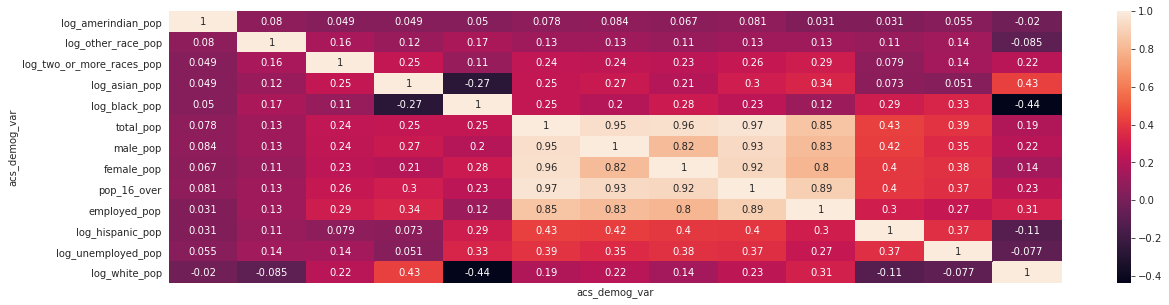

In [17]:
pop_corr = census_tb[all_pop_cols].corr()

fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(pop_corr, 
                 cmap = 'rocket',  annot = True,  xticklabels=False)
plt.show()

**INSIGHTS FROM POPULATION COLUMNS**
- pop_gr_4 are very highly correlated between themselves
- Distribution shows that there is a clear difference between minorities and rest of groups, having the most clear log-normal distribution
- Negative skewness and outliers for low values seams to be the tendency for this group
- Asian population and White population are inversely correlated to black population

### 3.3.2
### MEDIAN COLUMNS INSIGHTS

In [18]:
# SEARCHING FOR THOSE COLUMNS
median_cols = [col for col in census_tb.columns if len(re.findall('median', col))]

for col in median_cols:
    fltr = census_tb[col] != 0
    print(f"Num of elements:  {census_tb[fltr].shape[0]}\t\t Num.of unique elements:  {len(census_tb[col].unique())} \t\t{col}\t\v")

Num of elements:  6339		 Num.of unique elements:  507 		median_age	
Num of elements:  6339		 Num.of unique elements:  4983 		median_income	
Num of elements:  6339		 Num.of unique elements:  1865 		median_rent	
Num of elements:  3671		 Num.of unique elements:  76 		median_year_structure_built	
Num of elements:  6339		 Num.of unique elements:  3248 		owner_occupied_housing_units_median_value	
Num of elements:  6339		 Num.of unique elements:  1891 		renter_occupied_housing_units_paying_cash_median_gross_rent	


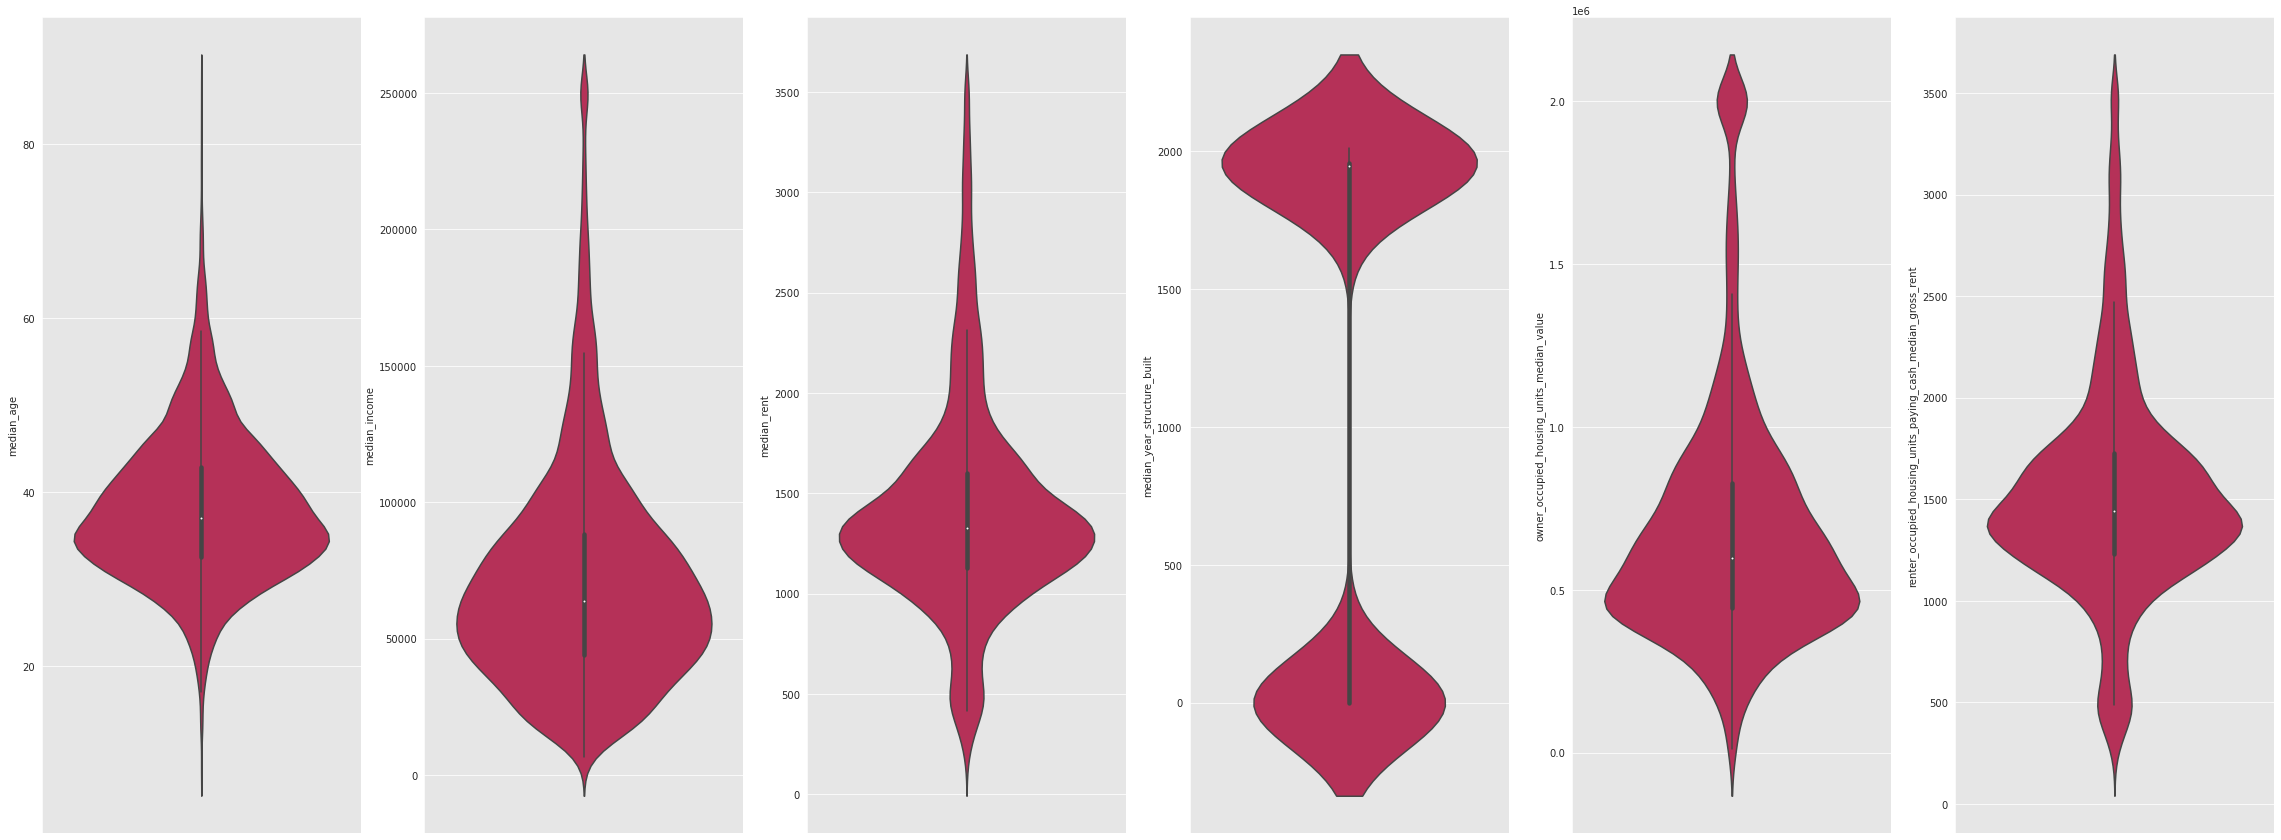

In [19]:
# DISTRIBUTION IN MEDIAN COLUMNS          
fig, ax = plt.subplots(ncols = len(median_cols), nrows = 1, figsize = (40,15))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(median_cols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[2])

plt.show()

In [20]:
# Aggrupation of data taking into account distributions

med_gr_1 = ['median_year_structure_built']                                   
med_gr_2 = ['median_age']                                 
med_gr_3 = ['median_rent', 'renter_occupied_housing_units_paying_cash_median_gross_rent']                                                          
med_gr_4 = ['median_income', 'owner_occupied_housing_units_median_value'] 

all_med_cols = med_gr_1 + med_gr_2 + med_gr_3 + med_gr_4

# In constract with population data, in this case, no log-normal distr in sight
# median_year_structure_built has a bimodal distribution with most data around 0 and 1990-2000

array([   0., 1955., 1956., 1953., 1954., 1952., 1946., 1957., 1948.,
       1949., 1945., 1951., 1963., 1944., 1947., 1958., 1950., 1964.,
       1961., 1941., 1942., 1943., 1962., 1959., 1965., 1960., 1966.,
       1967., 1940., 1974., 1971., 1968., 1973., 1972., 1975., 1969.,
       1970., 1983., 1985., 1980., 1981., 1977., 1976., 2003., 1982.,
       1984., 1978., 1979., 1995., 2001., 1990., 1993., 1986., 1992.,
       2002., 2000., 1996., 1991., 2004., 1988., 1989., 1994., 2006.,
       2010., 1999., 1987., 1997., 1998., 2007., 2005., 2011., 2009.,
       2012., 2013.,   18.])

array([2668,  162,  143,  140,  139,  122,  114,  114,  113,  109,  109,
        108,  107,  106,  104,  102,  102,   99,   98,   98,   96,   95,
         91,   84,   74,   68,   66,   51,   47,   42,   39,   37,   35,
         33,   31,   31,   30,   27,   25,   24,   24,   21,   21,   19,
         18,   17,   17,   16,   16,   15,   15,   14,   14,   14,   12,
         11,   11,   10,    8,    7,    7,    5,    5,    5,    5,    5,
          4,    4,    4,    3,    3,    3,    1,    1,    1])

dtype('float64')

Nulls: 100


2768

dtype('int64')

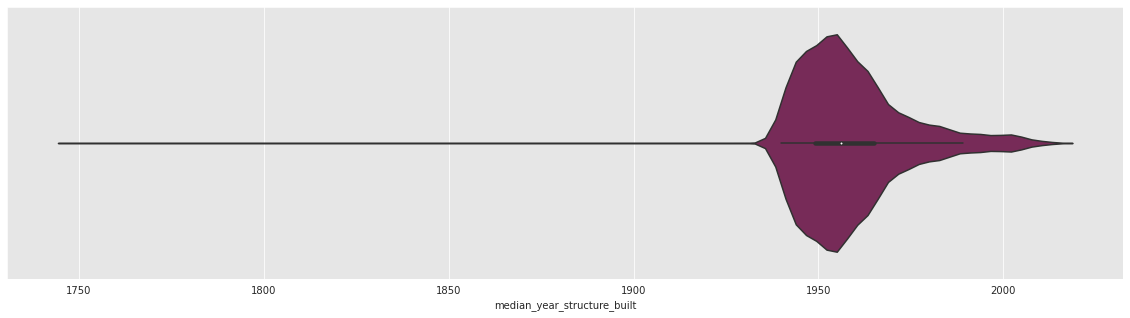

In [21]:
# Lets have a look at that year column, what does zero indicate?
display(np.array(census_tb['median_year_structure_built'].value_counts().index.tolist()))
display(np.array(census_tb['median_year_structure_built'].value_counts().tolist()))
# array only to see all values in condensated way

display(census_tb['median_year_structure_built'].dtype)
print(f"Nulls: {census_tb['median_year_structure_built'].isna().sum()}")

# It should be an integer col instead a float dtype of col
# NaNs and zeros indicate the same --> Unknown date of construction
# Lets get rid of NaN values

def zero_ifNan(x):
    if isnan(x): return 0.
    elif x == 18: return 1750. # there are values marked as 18 which is may indicate the century
    elif x == 19: return 1850.
    elif x == 20: return 1900.
    else: return x

census_tb['median_year_structure_built'] = census_tb['median_year_structure_built'].apply(zero_ifNan)

# Once there arent any Null values, lets change column data type
census_tb['median_year_structure_built'] = census_tb['median_year_structure_built'].astype('int64')

fltr = (census_tb['median_year_structure_built'] == 0)
display(census_tb[fltr].shape[0])
display(census_tb['median_year_structure_built'].dtype)

# Let's have a look at its distribution without taking into account unknown construction year

fig, ax = plt.subplots(figsize = (20,5))
sns.violinplot(x = census_tb[~fltr]['median_year_structure_built'], color = rocket_palette[1])
plt.show()

# Makes more sense:
# Most of buildings in NYC are built around 1940-1980
# Which is the era of sprawling and big urban growth in first world countries

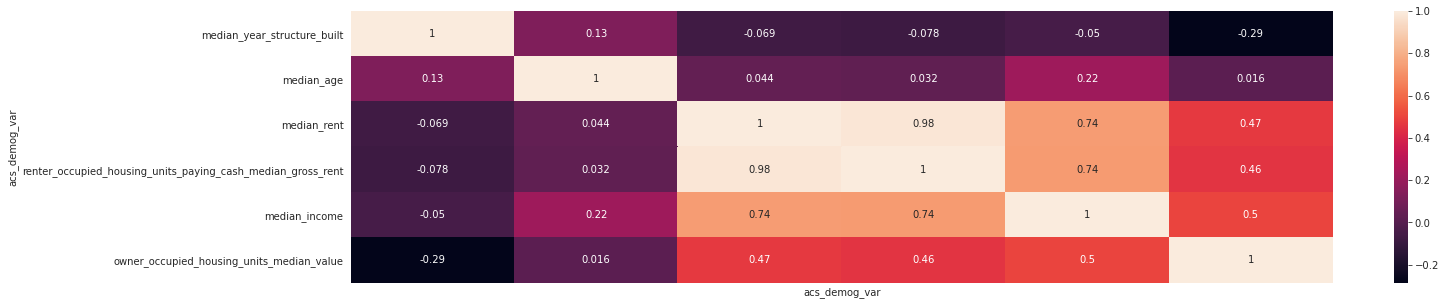

In [22]:
med_corr = census_tb[all_med_cols].corr()

fig, ax = plt.subplots(figsize = (22,5))
ax = sns.heatmap(med_corr, 
                 cmap = 'rocket',  annot = True, xticklabels = False)
plt.show()

**INSIGHTS FROM MEDIAN COLUMNS**

These 6 columns could be represented through different agrupations:
- Group 1: 'median_year_structure_built'
- Group 2: 'median_age',
- Group 3: 'median_rent', 'renter_occupied_housing_units_paying_cash_median_gross_rent'
- Group 4: 'median_income', 'owner_occupied_housing_units_median_value'


*Notes____*
- Group 3 is very highly correlated between each other
- median_rent and median_income are also HIGHLY CORRELATED which is a bit evident: *The more income you receibe, the better housing you can afford*.
- median_year_structure_built is INVERSELY correlated with owner_occupied_housing_units_median_value: *The older the house, the less probable it is that is occupied by its owner* or it could be also that *People buy newer houses as their home*
- Data distribution if more normal than the population data except for median_age and owner_occupied_housing_units_median_value which have a SLIGHT POSITIVE SKEWNESS.
- OUTLIERS for high values
- Median_year_structure_built have a multimodal distribution because a lot of builing have unknown year of construction

### 3.3.3
### HOUSING COLUMNS INSIGHTS

In [23]:
# SEARCHING FOR THOSE COLUMNS
house_cols = [col for col in census_tb.columns if len(re.findall('hous', col))]

for col in house_cols:
    fltr = census_tb[col] != 0
    print(f"Num of elements:  {census_tb[fltr].shape[0]}\t\t Num.of unique elements:  {len(census_tb[col].unique())} \t\t{col}\t\v")

Num of elements:  6250		 Num.of unique elements:  747 		family_households	
Num of elements:  6262		 Num.of unique elements:  1107 		households	
Num of elements:  6263		 Num.of unique elements:  1193 		housing_units	
Num of elements:  6207		 Num.of unique elements:  1003 		housing_units_renter_occupied	
Num of elements:  6224		 Num.of unique elements:  580 		married_households	
Num of elements:  6221		 Num.of unique elements:  746 		nonfamily_households	
Num of elements:  6262		 Num.of unique elements:  1107 		occupied_housing_units	
Num of elements:  6339		 Num.of unique elements:  3248 		owner_occupied_housing_units_median_value	
Num of elements:  6339		 Num.of unique elements:  1891 		renter_occupied_housing_units_paying_cash_median_gross_rent	
Num of elements:  4979		 Num.of unique elements:  341 		vacant_housing_units	
Num of elements:  2275		 Num.of unique elements:  156 		vacant_housing_units_for_rent	


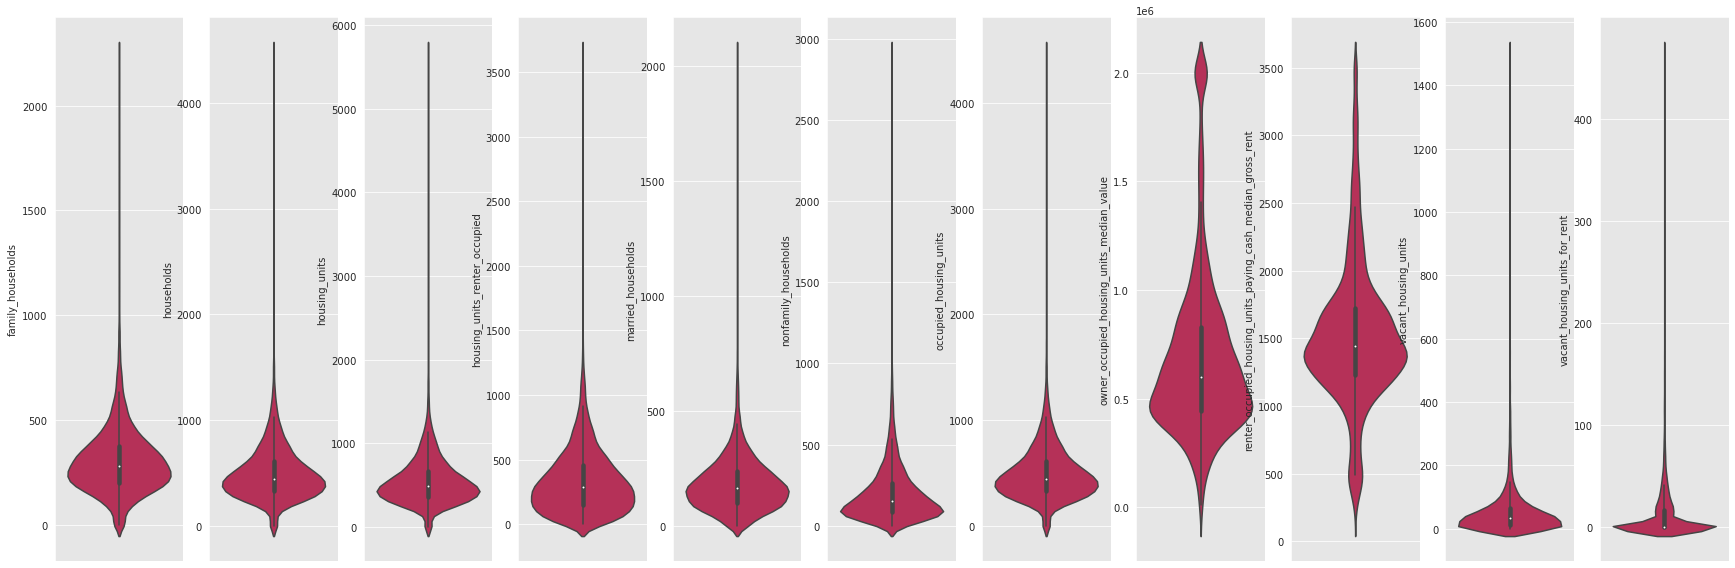

In [24]:
fig, ax = plt.subplots(ncols = len(house_cols), nrows = 1, figsize = (30,10))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(house_cols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[2])

plt.show()

In [25]:
# Aggrupation of data taking into account distributions

hous_gr_1 = ['married_households']
hous_gr_2 = ['households', 'housing_units', 'family_households', 'occupied_housing_units', 
             'housing_units_renter_occupied', 'nonfamily_households']
hous_gr_3 = ['owner_occupied_housing_units_median_value', 
            'renter_occupied_housing_units_paying_cash_median_gross_rent']
hous_gr_4 = ['vacant_housing_units_for_rent', 'vacant_housing_units']
    
# except for hous_gr_3 most of the data has a LOG-NORMAL DISTRIBUTION
hous_gr_cols = hous_gr_1 + hous_gr_2 + hous_gr_4 

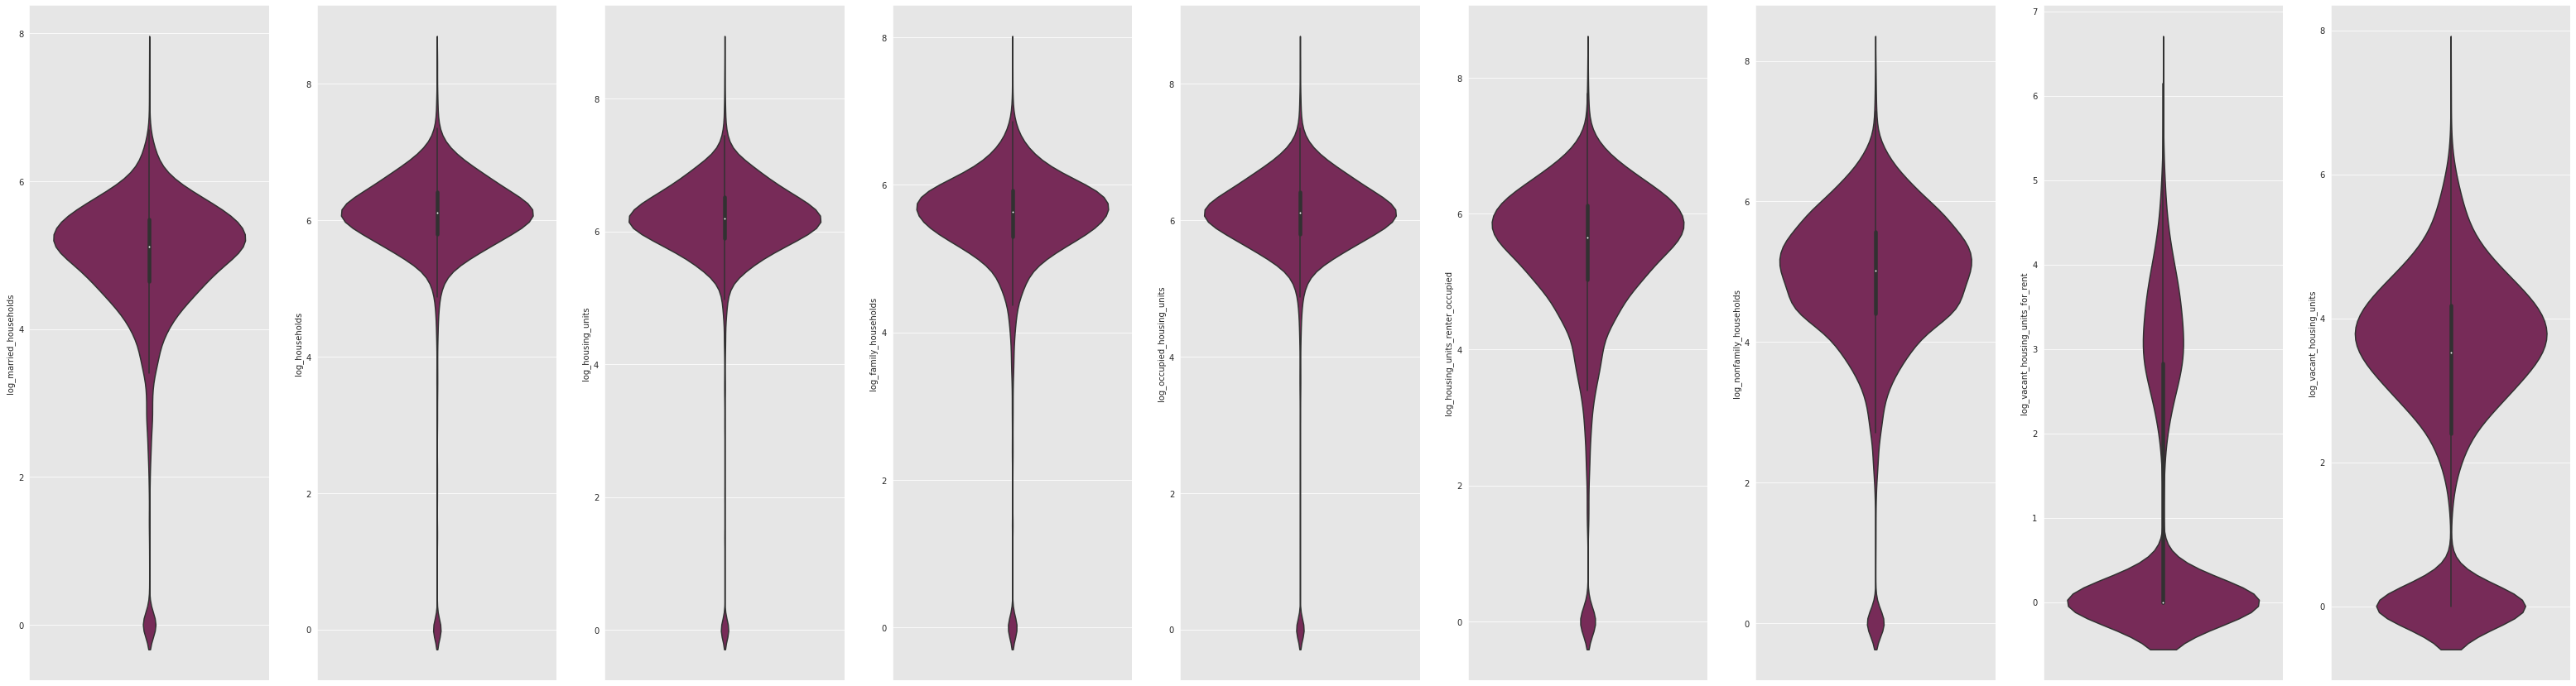

In [26]:
# LETS HAVE A LOOK INTO COLS WITH LOG-NORMAL DISTR
log_hcols = []
for col in hous_gr_cols:
    census_tb[f"log_{col}"] = census_tb.apply(lambda x: np.log(x[col]) if x[col] > 0 else x[col], axis = 1)
    log_hcols.append(f"log_{col}")


fig, ax = plt.subplots(ncols = len(log_hcols), nrows = 1, figsize = (55,15))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(log_hcols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[1])

plt.show()

**Conclusions from columns distributions**
- pop_gr_1 and pop_gr_2 => *They have outliers for low values and a their logaritmic is more clear*
- pop_gr_3 => *Positive skewness and outliers for high values*
- pop_gr_4 => *Bimodal distribution at their logaritmic*

**______**

For pop_gr_1, 2 and 4 initial columns are replace with their log and dropped
Since log(col data9 has the same effect as in the case of population data



In [27]:
# FINAL POPULATION COLUMNS AGGRUPATIONS
hous_gr_1 = ['log_married_households']

hous_gr_2 = ['log_households', 'log_housing_units', 'log_family_households', 'log_occupied_housing_units', 
             'log_housing_units_renter_occupied', 'log_nonfamily_households']
hous_gr_3 = ['owner_occupied_housing_units_median_value', 
            'renter_occupied_housing_units_paying_cash_median_gross_rent']
hous_gr_4 = ['log_vacant_housing_units_for_rent', 'log_vacant_housing_units']

all_hous_cols = hous_gr_1 + hous_gr_2 + hous_gr_3 + hous_gr_4

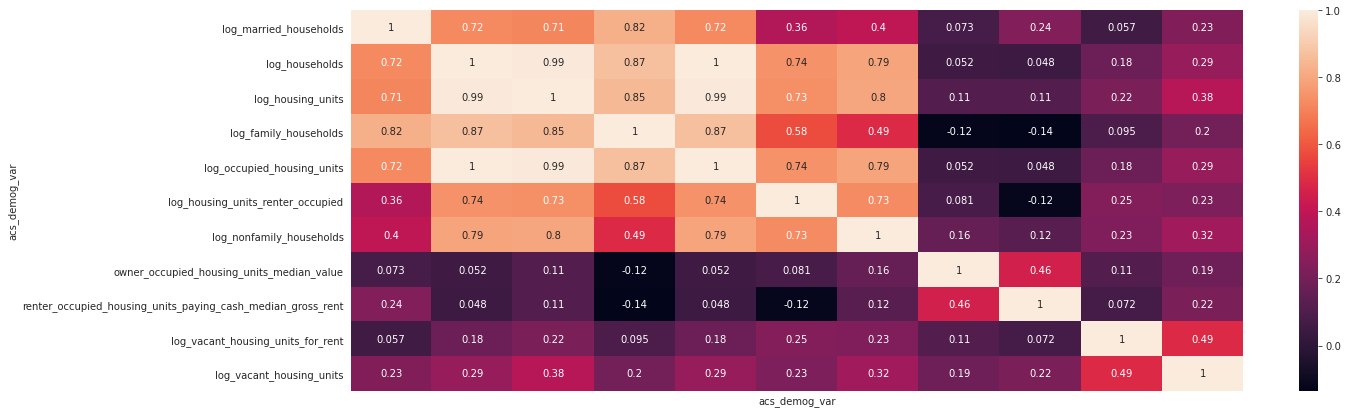

In [28]:
# CORRELATION MATRIX IN HOUSING COLUMNS
pop_corr = census_tb[all_hous_cols].corr()

fig, ax = plt.subplots(figsize = (20,7))
ax = sns.heatmap(pop_corr, 
                 cmap = 'rocket',  annot = True, xticklabels = False)
plt.show()

**INSIGHTS FROM HOUSING COLUMNS**

These 11 columns could be represented through different agrupations, having seen both the distr and corr:
- hous_gr_1: 'married_households'
- hous_gr_2: 'households', 'housing_units', 'family_households', 'occupied_housing_units', 
             'housing_units_renter_occupied', 'nonfamily_households'
- hous_gr_3: 'owner_occupied_housing_units_median_value', 
            'renter_occupied_housing_units_paying_cash_median_gross_rent'
- hous_gr_4: 'vacant_housing_units_for_rent', 'vacant_housing_units'


*Notes____*
- hous_gr_1 and hous_gr_2 are highly correlated, which mean that *each household belongs to a single family*
- hous_gr_2 is the most uniform of the lot, with clear correlations ans similar distribution violins
- hous_gr_3 have POSITIVE SKEWNESS, the rest of groups have a slight negative skewness
- hous_gr_4 has a bimodal distribution, following the same trend as for the Pop data
- there are OUTLIERS for extreme values.


### 3.3.4
### REST OF COLUMNS INSIGHTS

In [29]:
# DISTR OF REST OF COLS
rest_cols = ['aggregate_travel_time_to_work', 'commuters_16_over', 'commuters_by_public_transportation', 
            'families_with_young_children', 'income_per_capita']
for col in rest_cols:
    fltr = census_tb[col] != 0
    print(f"Num of elements:  {census_tb[fltr].shape[0]}\t\t Num.of unique elements:  {len(census_tb[col].unique())} \t\t{col}\t\v")

Num of elements:  6339		 Num.of unique elements:  352 		aggregate_travel_time_to_work	
Num of elements:  6263		 Num.of unique elements:  1309 		commuters_16_over	
Num of elements:  6251		 Num.of unique elements:  984 		commuters_by_public_transportation	
Num of elements:  5786		 Num.of unique elements:  417 		families_with_young_children	
Num of elements:  6339		 Num.of unique elements:  5931 		income_per_capita	


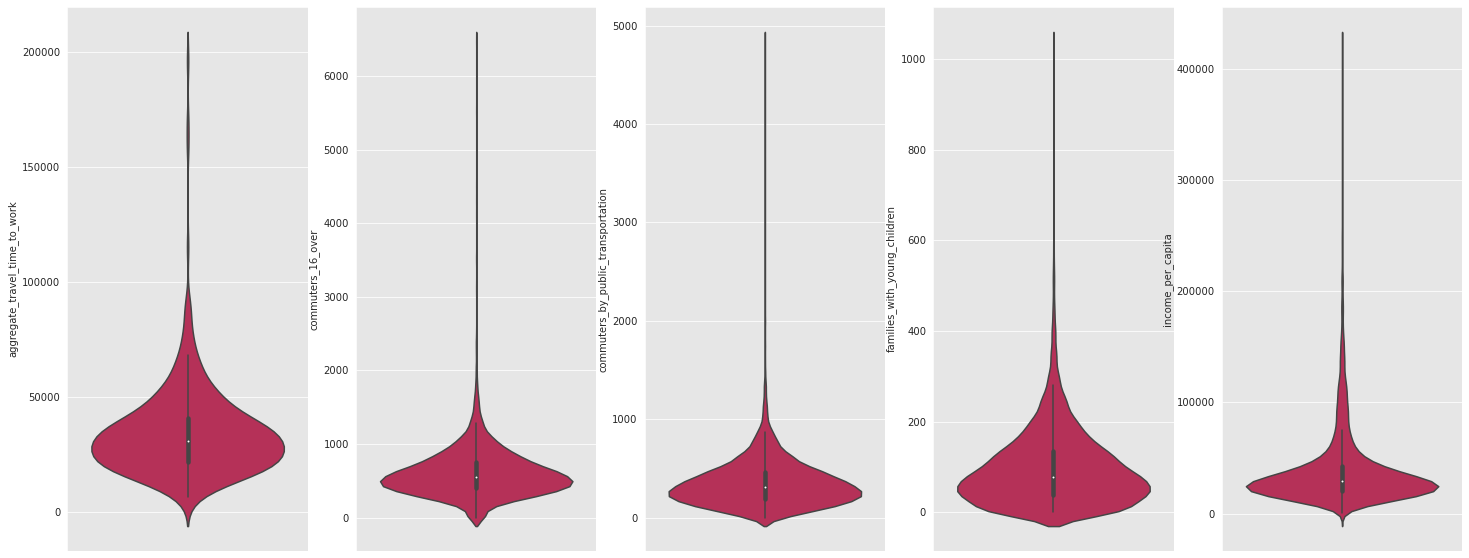

In [30]:
fig, ax = plt.subplots(ncols = len(rest_cols), nrows = 1, figsize = (25,10))
fig.subplots_adjust(hspace = 0.3)

for i, col in enumerate(rest_cols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[2])

plt.show()

In [31]:
# Aggrupation of data taking into account distributions

rest_gr_1 = ['aggregate_travel_time_to_work']
rest_gr_2 = ['commuters_16_over', 'commuters_by_public_transportation']
rest_gr_3 = ['families_with_young_children']
rest_gr_4 = ['income_per_capita']

all_rest_cols = rest_gr_1 + rest_gr_2 + rest_gr_3 + rest_gr_4

All of them seem to benefit from having a look at their logaritmic distr!

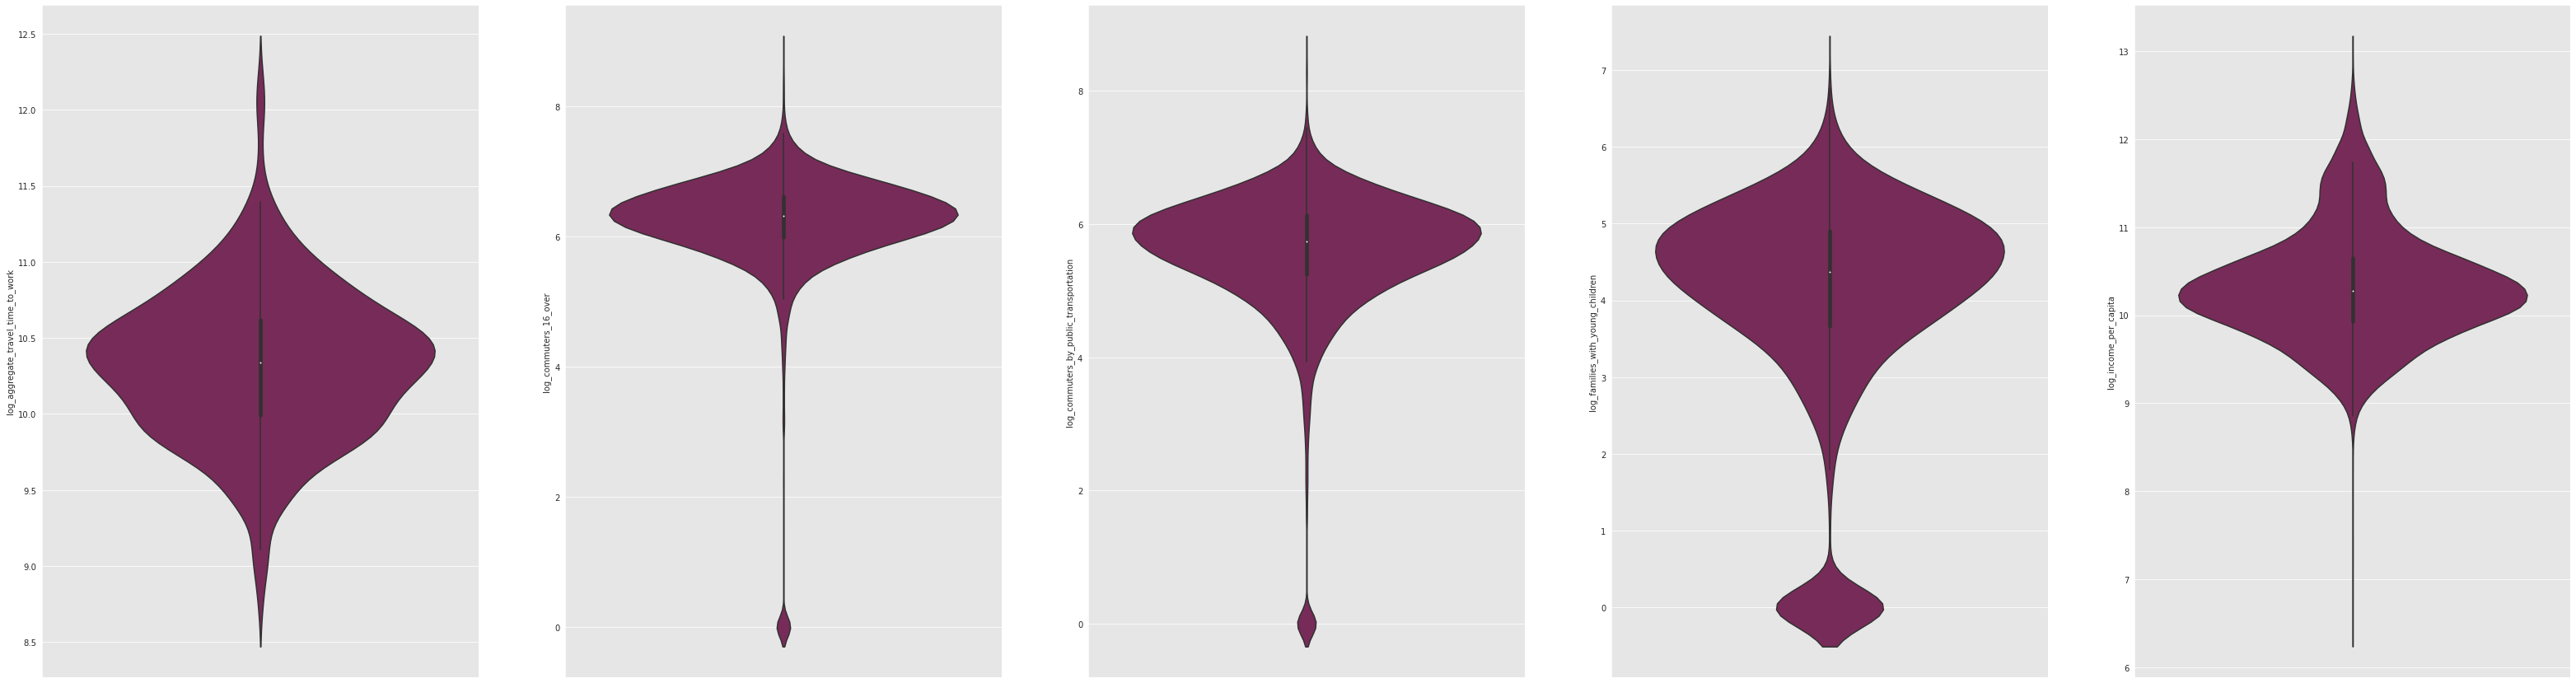

In [32]:
log_rcols = []
for col in all_rest_cols:
    census_tb[f"log_{col}"] = census_tb.apply(lambda x: np.log(x[col]) if x[col] > 0 else x[col], axis = 1)
    log_rcols.append(f"log_{col}")


fig, ax = plt.subplots(ncols = len(log_rcols), nrows = 1, figsize = (55,15))
fig.subplots_adjust(hspace = 0.5)

for i, col in enumerate(log_rcols):
    sns.violinplot(y = census_tb[col], ax = ax[i], color = rocket_palette[1])

plt.show()

**Conclusions from columns distributions**
- rest_gr_1: logaritmic data show a far more normal dist with sligh neg skewness
- rest_gr_2: Outliers for very low values
- rest_gr_3: bimodal distr with the same look as previous columns
- rest_gr_4: has a slight different dist as the rest of dataset columns

**______**

All columns are replaced with their logaritmic since they have a more normalized distribution


In [33]:
# FINAL POPULATION COLUMNS AGGRUPATIONS
rest_gr_1 = ['log_aggregate_travel_time_to_work']
rest_gr_2 = ['log_commuters_16_over', 'log_commuters_by_public_transportation']
rest_gr_3 = ['log_families_with_young_children']
rest_gr_4 = ['log_income_per_capita']

all_rest_cols = rest_gr_1 + rest_gr_2 + rest_gr_3 + rest_gr_4

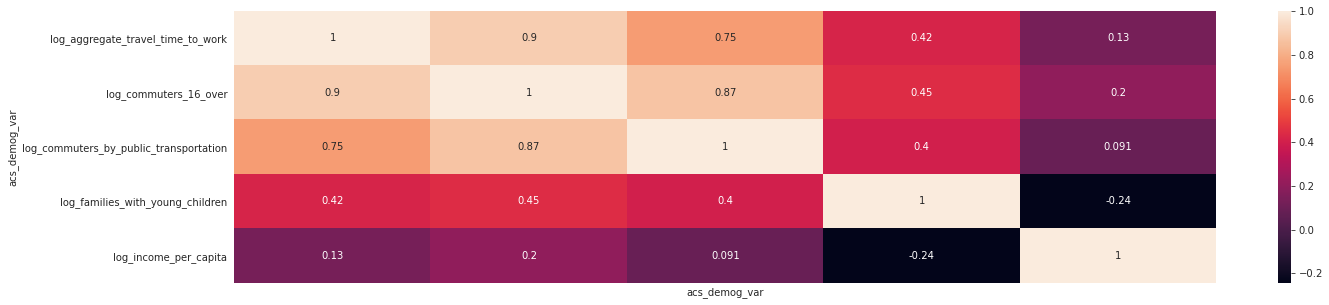

In [34]:
pop_corr = census_tb[all_rest_cols].corr()

fig, ax = plt.subplots(figsize = (22,5))
ax = sns.heatmap(pop_corr, 
                 cmap = 'rocket',  annot = True,  xticklabels = False)
plt.show()

**INSIGHTS FROM REST OF COLUMNS**

- Columns related with mobility (time_to_work, commuting etc9 have a high correlation, though their distribution may vary
- Log_income_per_capita is INVERSELY CORRELATED with families with young children. This may that *Rich neighborhoods (where income per capita is high) are less likely to be areas with a lot of young families*

### 3.3.5
### ZOOM IN CORRELATION BETWEEN MOST REPRESENTATIVE COLUMNS

In [35]:
repr_cols = [pop_gr_1[0], pop_gr_2[0], pop_gr_3[0], pop_gr_4[0], pop_gr_5[0],  pop_gr_6[0],
            med_gr_1[0], med_gr_2[0], med_gr_3[0], med_gr_4[0],
            hous_gr_1[0], hous_gr_2[0], hous_gr_3[0], hous_gr_4[0],
            rest_gr_1[0], rest_gr_2[0], rest_gr_3[0], rest_gr_4[0]]
len(repr_cols)

18

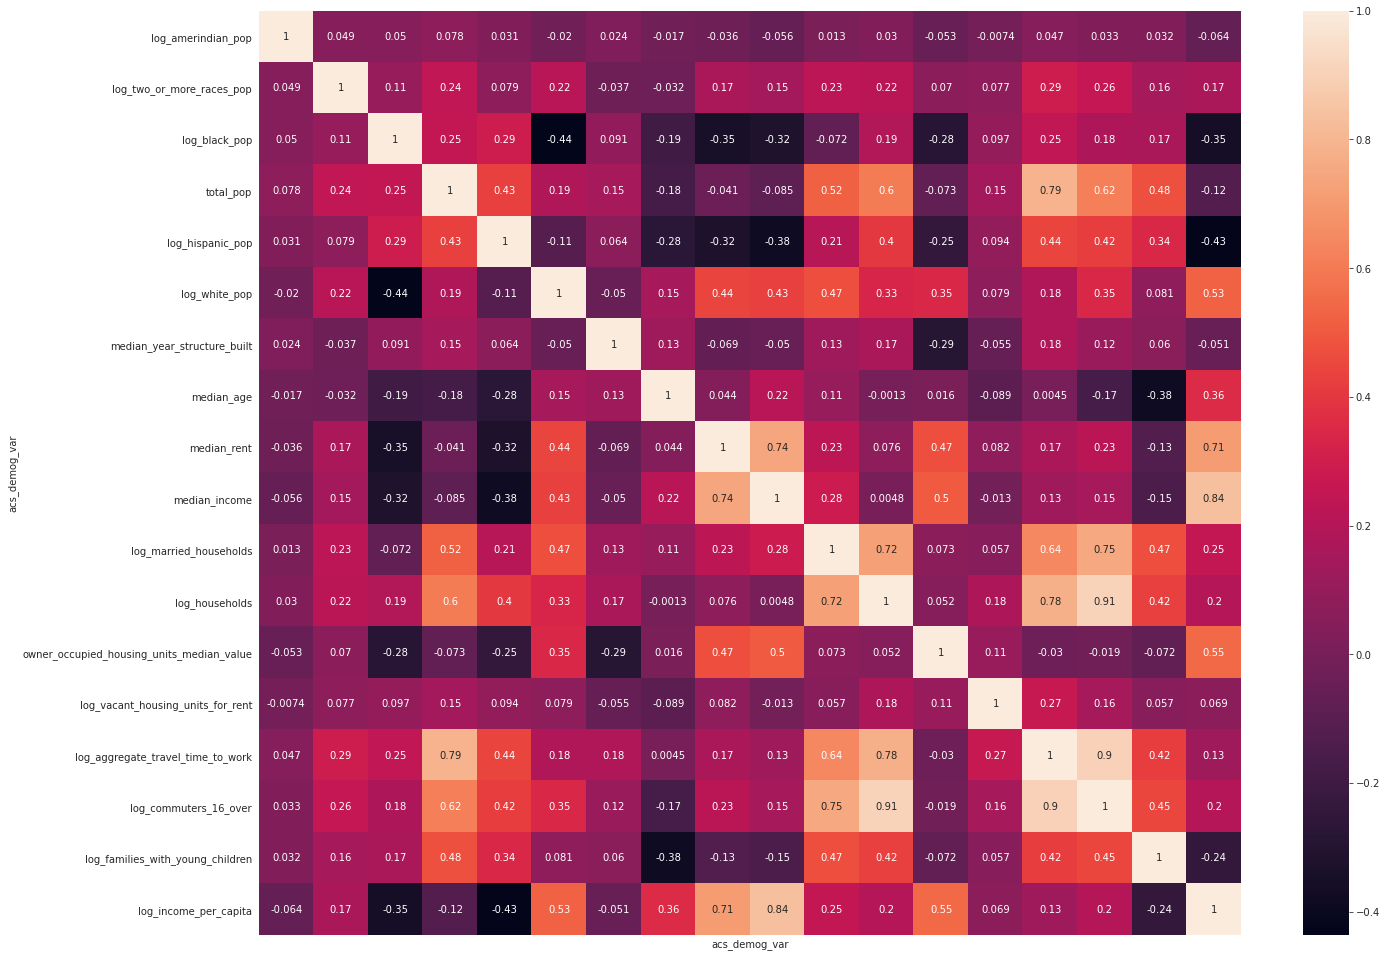

In [36]:
# corr matrix
all_corr = census_tb[repr_cols].corr()

fig, ax = plt.subplots(figsize = (22,17))
ax = sns.heatmap(all_corr, 
                 cmap = 'rocket',  annot = True,   xticklabels = False)
plt.show()

**CROSS CONCLUSIONS**
- Amerindian population is UNCORRELATED to the rest of the data: *Native american tribes live isolated from the rest of population*
- Prominent black and hispanic neiborhoods suffer the most of:
> - Have more unemployment
> - Live in house with less value and cheaper rent
> - Are poorer (lower income)
> - Are less likely to be the owner of their home
> - Have less income_per_capita

- Married households, households, housing units member occupied, aggegate time to work, commuters 16 over and commuters by public transportation are HIGHLY correlated: *traditional families are the ones that commute the most and life fardest from workplaces.*

- Higher time in commuting and traveling to work is highlt correlated with households and married households, which reflects on the suburbs being more atractive for families.

- Also notice how total_pop and log_aggregate time to work are highly correlated, which indicates that most people live far from their workplaces.

## PT 3 OUTLIERS

- Through the distribution visualization it is clear that there are outliers for high values for most of the dataset columns. 

- Because every row represents a shape, the strategy to deal with outliers is to flag them with a column.

- Everything outside the range of 5-95% interquartile will be considered an outlier; therefore, the bounds used to single out the outliers are:
>- 05th Percentile - IQR x 1.25
>- 95th Percentile + iqr x 1.25

In [37]:
q05 = census_tb.quantile(0.05)
q95 = census_tb.quantile(0.95)

iqr = q95 - q05

In [38]:
# Lets have a look at those outliers
filtr_outliers = ((census_tb < (q05 - 1.25*iqr)) | (census_tb > (q95 + 1.25*iqr )))

list_is_outlier = []
for i in range(census_tb.shape[0]):
    if i in census_tb[filtr_outliers.any(axis = 1)].index.tolist(): list_is_outlier.append(True)
    else: list_is_outlier.append(False)

census_tb['is_outlier'] = list_is_outlier  

In [39]:
census_tb.head()

acs_demog_var         geoid  aggregate_travel_time_to_work  amerindian_pop  \
0              360050001001                            NaN            25.0   
1              360050002001                            NaN             0.0   
2              360050002002                            NaN             0.0   
3              360050002003                            NaN             0.0   
4              360050004001                            NaN             0.0   

acs_demog_var  asian_pop  black_pop  commuters_16_over  \
0                  125.0     3984.0                0.0   
1                    0.0      468.0              608.0   
2                    0.0      238.0              579.0   
3                  104.0      202.0              382.0   
4                   24.0       24.0              213.0   

acs_demog_var  commuters_by_public_transportation  employed_pop  \
0                                             0.0           0.0   
1                                           271.0         608.0   
2                                           161.0         588.0   
3                                           108.0         382.0   
4                                            69.0         259.0   

acs_demog_var  families_with_young_children  family_households  ...  \
0                                       0.0                0.0  ...   
1                                      63.0              356.0  ...   
2                                      96.0              363.0  ...   
3                                      33.0              239.0  ...   
4                                       0.0              136.0  ...   

acs_demog_var  log_housing_units_renter_occupied  log_nonfamily_households  \
0                                       0.000000                  0.000000   
1                                       5.556828                  4.709530   
2                                       5.598422                  4.867534   
3                                       4.624973                  4.859812   
4                                       4.343805                  4.430817   

acs_demog_var  log_vacant_housing_units_for_rent  log_vacant_housing_units  \
0                                        0.00000                  0.000000   
1                                        0.00000                  3.401197   
2                                        2.70805                  4.262680   
3                                        0.00000                  4.043051   
4                                        2.70805                  2.708050   

acs_demog_var  log_aggregate_travel_time_to_work  log_commuters_16_over  \
0                                            NaN               0.000000   
1                                            NaN               6.410175   
2                                            NaN               6.361302   
3                                            NaN               5.945421   
4                                            NaN               5.361292   

acs_demog_var  log_commuters_by_public_transportation  \
0                                            0.000000   
1                                            5.602119   
2                                            5.081404   
3                                            4.682131   
4                                            4.234107   

acs_demog_var  log_families_with_young_children  log_income_per_capita  \
0                                      0.000000               7.717351   
1                                      4.143135               9.886697   
2                                      4.564348              10.019491   
3                                      3.496508              10.263537   
4                                      0.000000              10.143134   

acs_demog_var  is_outlier  
0                    True  
1                   False  
2                   False  
3                   False  
4                   False  

[5 row

## PT 3.4
## DENDOGRAM

Looking for more relationships in the data

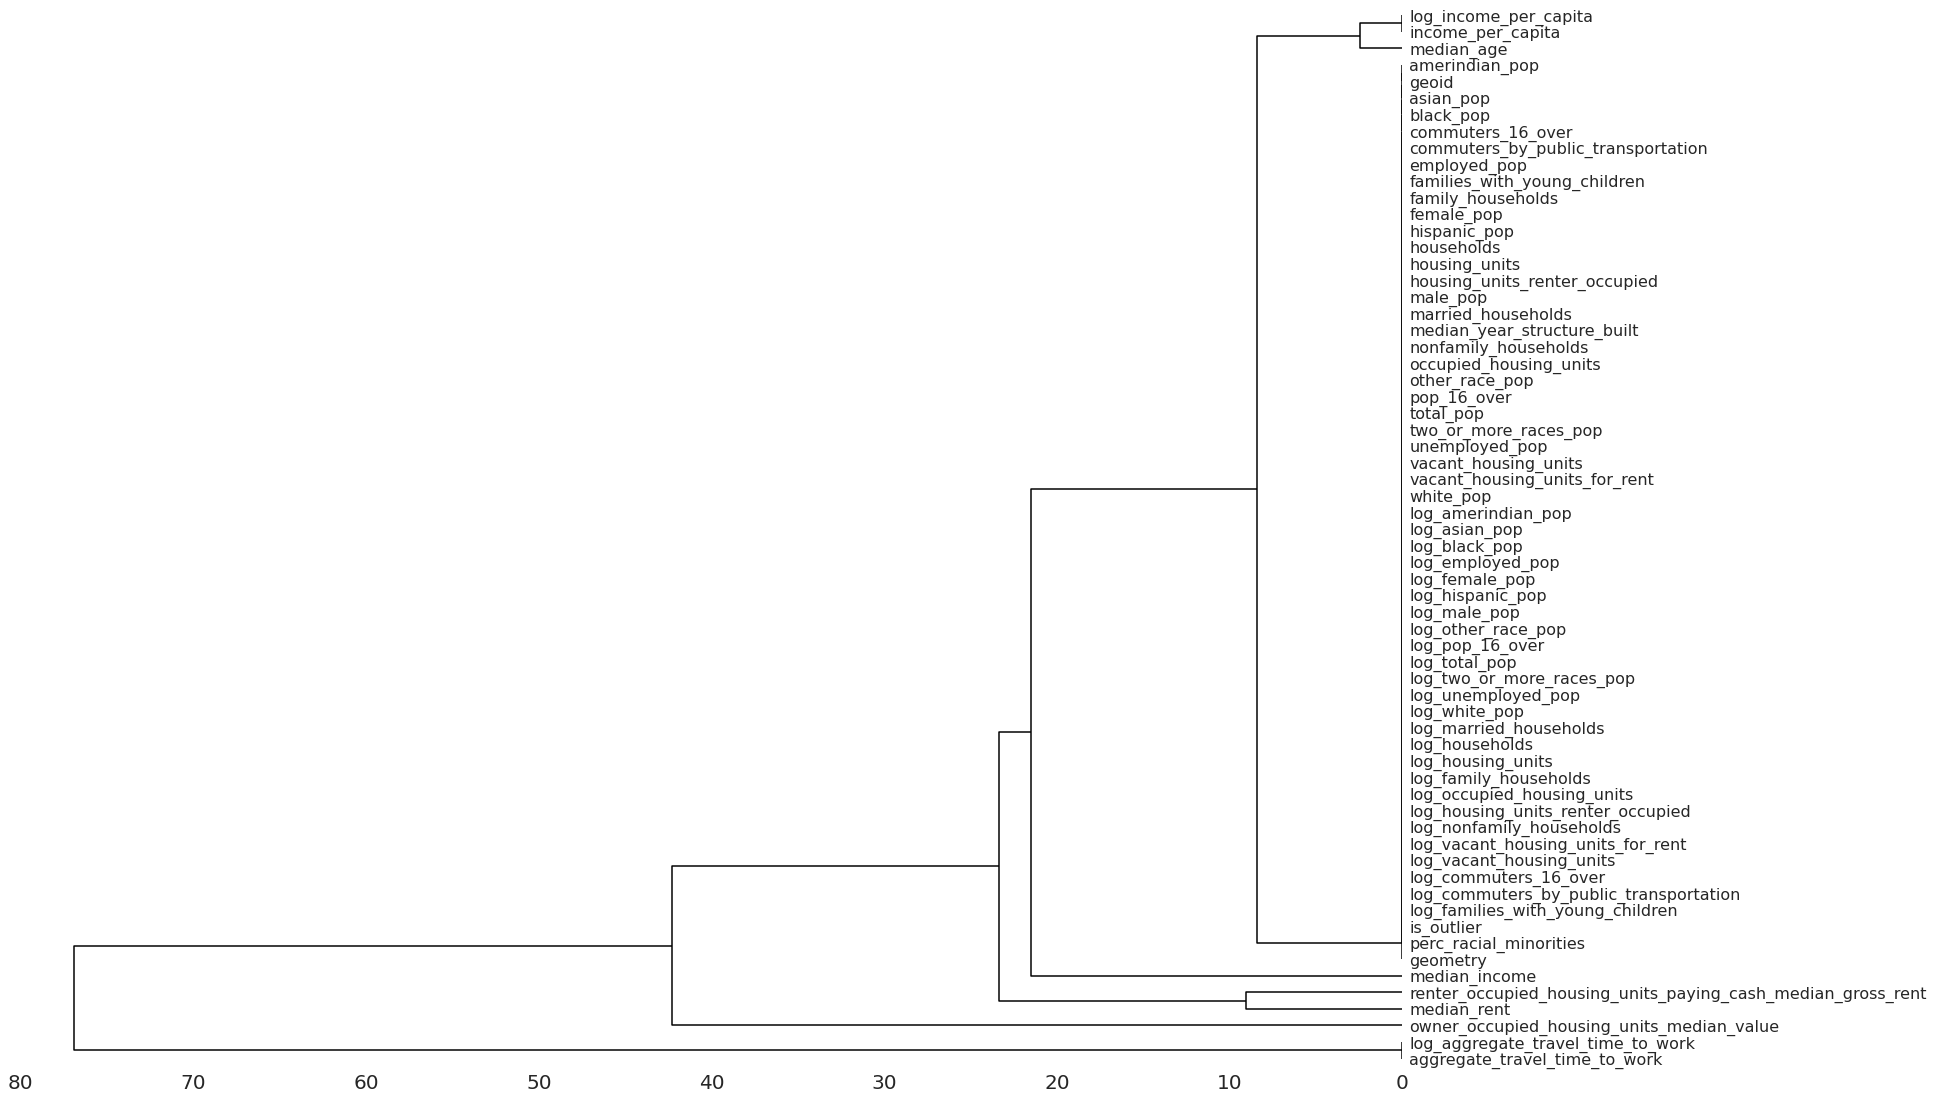

In [74]:
msno.dendrogram(census_tb)
plt.show()

There are two clusters to have a look into:
- income per capita vs median age
- median rent vs renter occupied house...

### 3.4.1

In [75]:
census_tb.columns

Index(['geoid', 'aggregate_travel_time_to_work', 'amerindian_pop', 'asian_pop',
       'black_pop', 'commuters_16_over', 'commuters_by_public_transportation',
       'employed_pop', 'families_with_young_children', 'family_households',
       'female_pop', 'hispanic_pop', 'households', 'housing_units',
       'housing_units_renter_occupied', 'income_per_capita', 'male_pop',
       'married_households', 'median_age', 'median_income', 'median_rent',
       'median_year_structure_built', 'nonfamily_households',
       'occupied_housing_units', 'other_race_pop',
       'owner_occupied_housing_units_median_value', 'pop_16_over',
       'renter_occupied_housing_units_paying_cash_median_gross_rent',
       'total_pop', 'two_or_more_races_pop', 'unemployed_pop',
       'vacant_housing_units', 'vacant_housing_units_for_rent', 'white_pop',
       'log_amerindian_pop', 'log_asian_pop', 'log_black_pop',
       'log_employed_pop', 'log_female_pop', 'log_hispanic_pop',
       'log_male_pop', 'log_oth

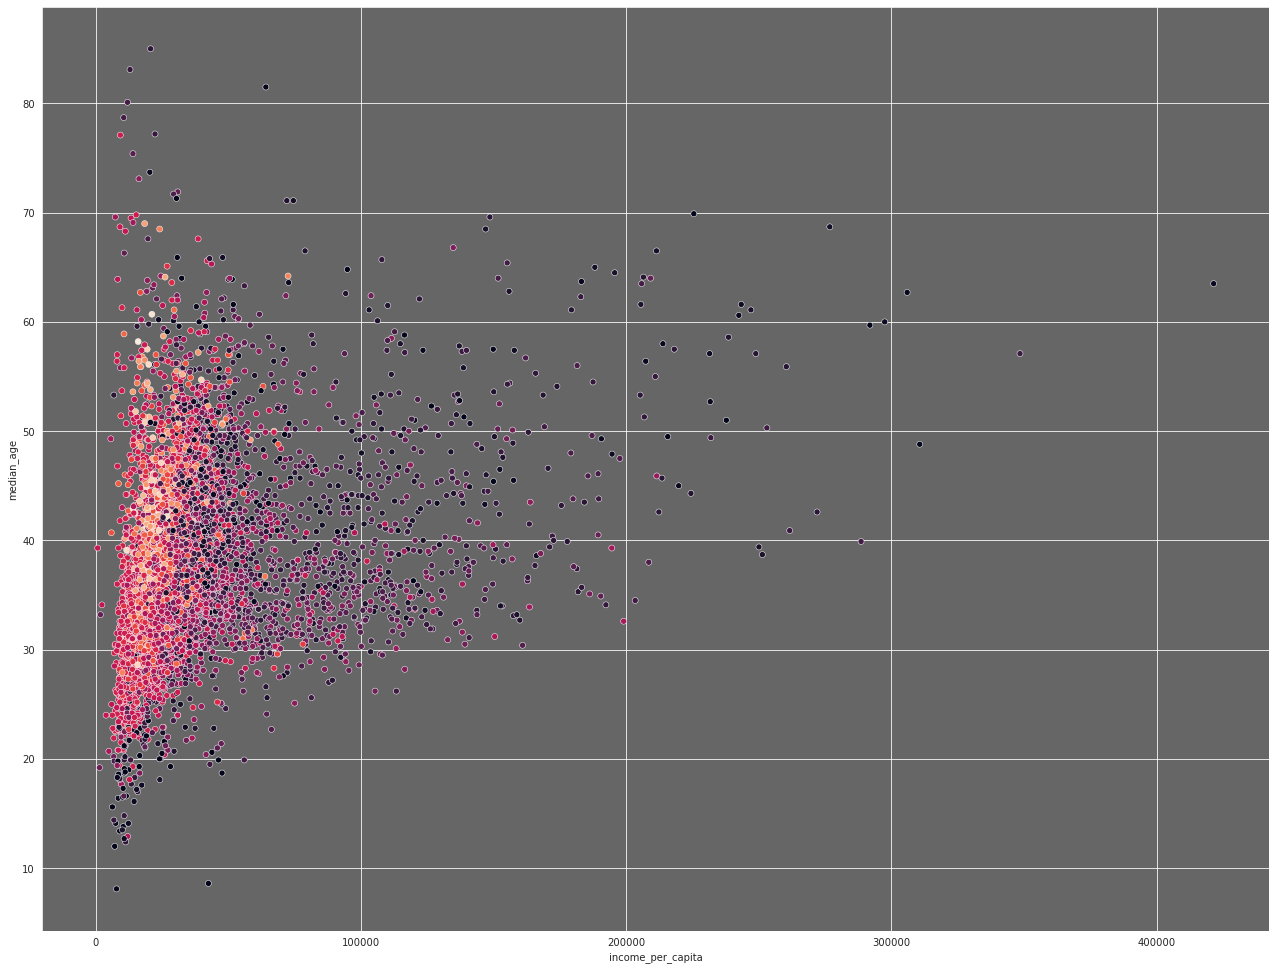

In [80]:
fig, ax = plt.subplots(figsize = (22,17))
sns.scatterplot(data = census_tb, 
                x = 'income_per_capita', 
                y = 'median_age', 
                palette = 'rocket', hue = 'perc_racial_minorities', legend = False)
plt.show()

Richer neighborhoods have little to nonexisten minorities and they are on the older side of the population pyramid.

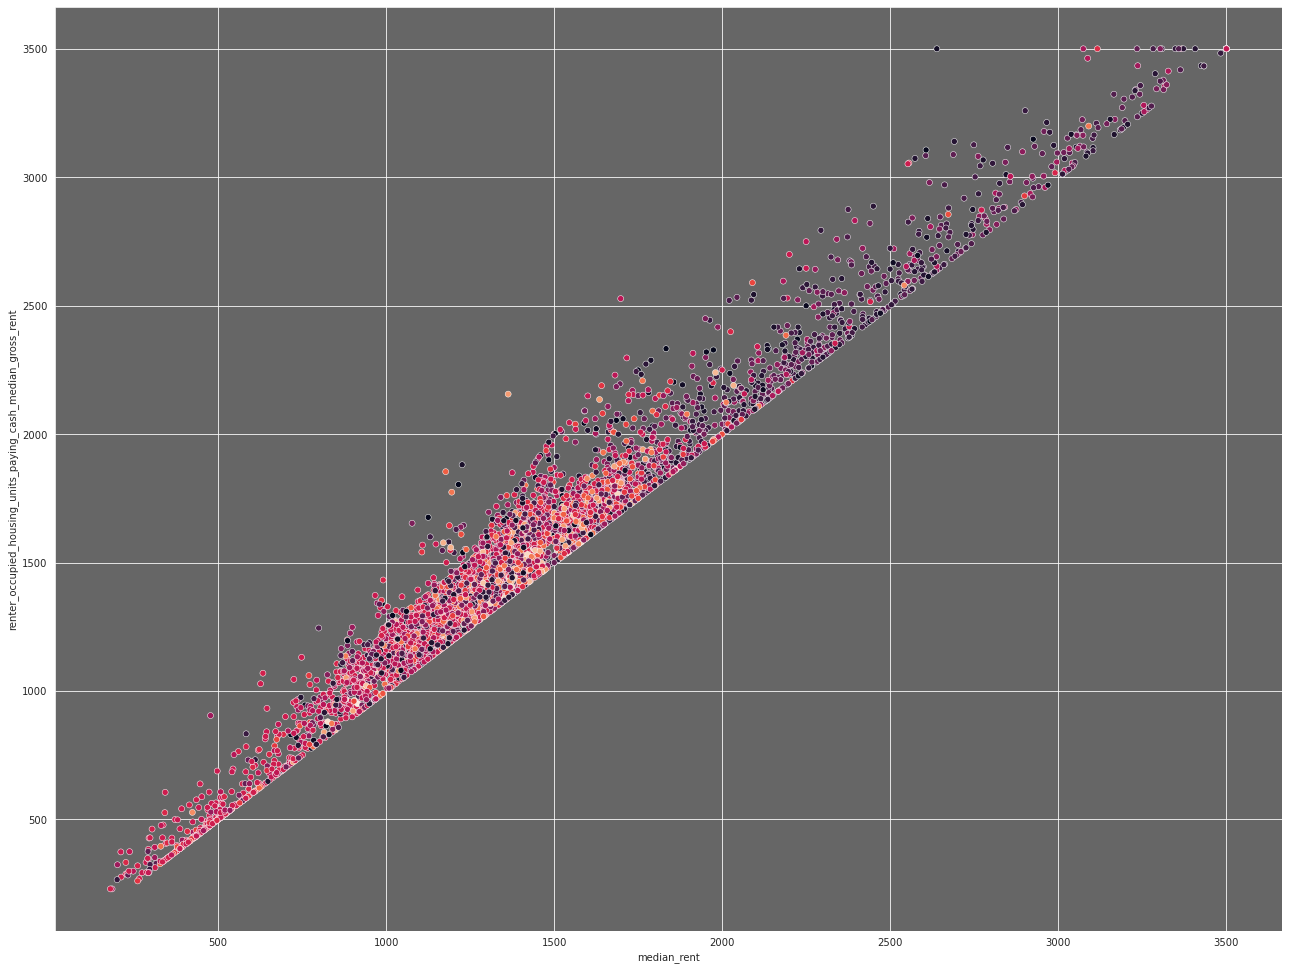

In [79]:
fig, ax = plt.subplots(figsize = (22,17))
sns.scatterplot(data = census_tb, 
                x = 'median_rent', 
                y = 'renter_occupied_housing_units_paying_cash_median_gross_rent', 
                palette = 'rocket', hue = 'perc_racial_minorities', legend = False)
plt.show()

renter_occupied_housing_units_paying_cash_median_gross_rent has such a linear relationship with median rent that could be dropped

## PT 3.5
## CLOSER LOOK INTO MOST RELATED DATA

Multivariate analysis into most related columns

### 3.5.1
### MINORITIES

In [41]:
def percentage(dividend, divisor):
    if divisor != 0: return np.around(dividend / divisor, 3)
    else: return 0

census_tb['perc_racial_minorities'] = census_tb.apply(lambda x: percentage(dividend = (x['black_pop'] + \
                                                                                       x['hispanic_pop'] + \
                                                                                       x['asian_pop'] + \
                                                                                       x['two_or_more_races_pop'] + \
                                                                                       x['asian_pop'] + \
                                                                                       x['other_race_pop']
                                                                                      )*100,
                                                                        divisor = x['total_pop']), 
                                                      axis = 1)

x_cols_to_repr = ['log_amerindian_pop', 'log_black_pop', 'log_hispanic_pop', 'log_white_pop', 'total_pop']

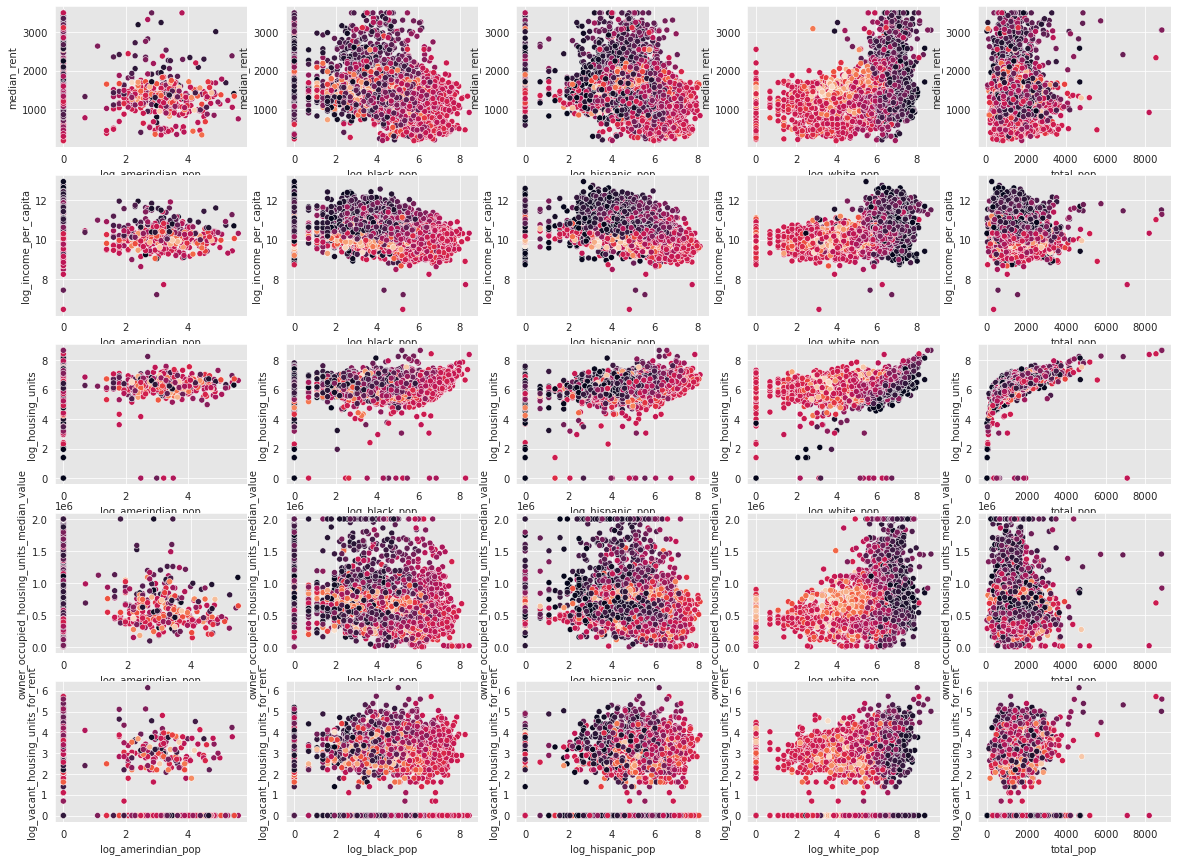

In [42]:
# MINORITIES AGAINST POVERTY INDICATORS
y_cols_to_repr = ['median_rent', 'log_income_per_capita', 'log_housing_units', 
                  'owner_occupied_housing_units_median_value', 'log_vacant_housing_units_for_rent']

fig, ax = plt.subplots(nrows = len(y_cols_to_repr), ncols = len(x_cols_to_repr), figsize = (20,15))

for i, x_col in enumerate(x_cols_to_repr):
    for j, y_col in enumerate(y_cols_to_repr):
        sns.scatterplot(data = census_tb, 
                        x = x_col, y = y_col, 
                        ax = ax[j][i], palette = 'rocket', hue = 'perc_racial_minorities', legend = False)  

plt.show()

# Clearer the higher is the percentage

While amerindian have a pretty homogenous tendency, it is clear that the higher the minority population in an
area, the more likely it is that rent, income and income_per_cap is lower.

Constrasting with my custom measure of minorities, my custom read of this viz knowing what it represent would be that those areas traditionally habitated with minorities that have been less atractive for new inhabitants have remained as areas of poverty. 

Also, it is noticiably the contrast of wealth in predominantly white areas: extreme wealth and poverty are attach to this ethnic label.

In general, this data doesnt show any difference between hispanic areas and black areas

### 3.5.2
### COMMUTING AND TYPE OF HOUSEHOLD

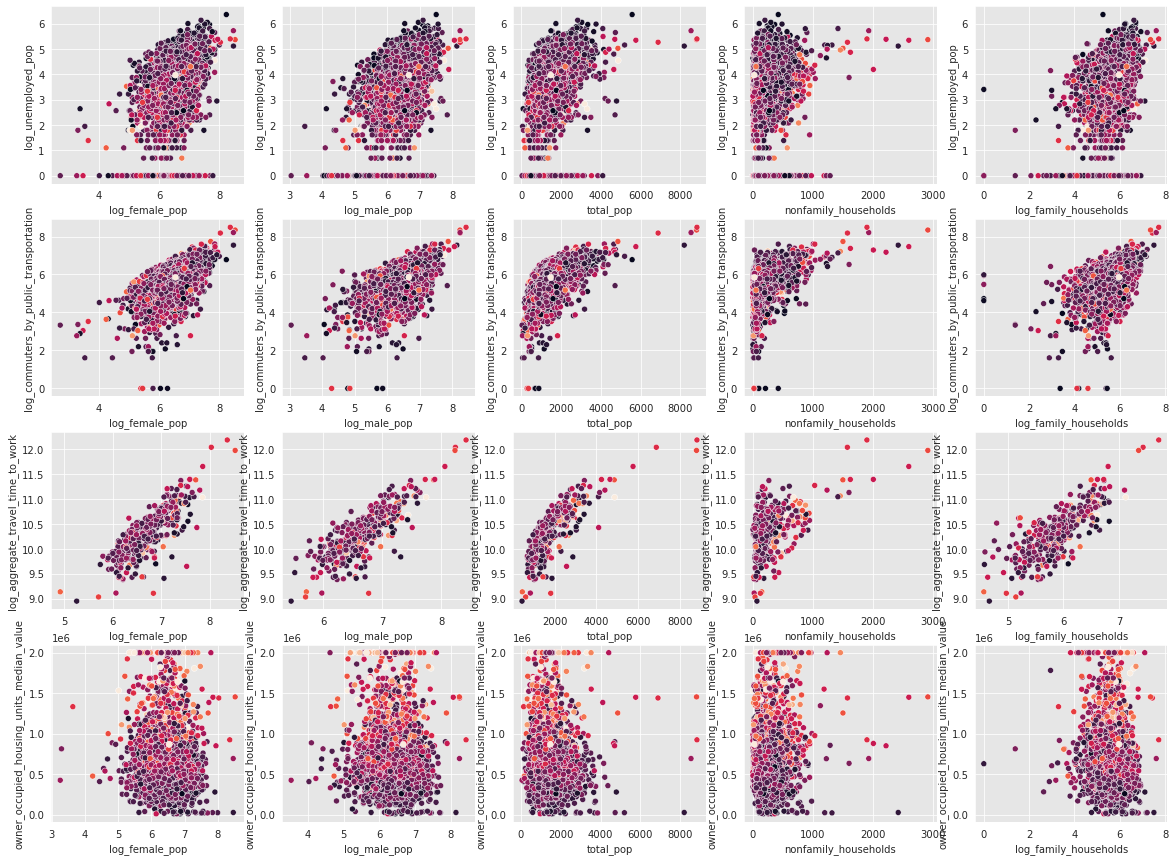

In [43]:
x_cols_to_repr = ['log_female_pop', 'log_male_pop', 'total_pop', 
                  'nonfamily_households', 'log_family_households']

y_cols_to_repr = ['log_unemployed_pop', 'log_commuters_by_public_transportation', 
                  'log_aggregate_travel_time_to_work', 
                  'owner_occupied_housing_units_median_value']

fig, ax = plt.subplots(nrows = len(y_cols_to_repr), ncols = len(x_cols_to_repr), figsize = (20,15))

for i, x_col in enumerate(x_cols_to_repr):
    for j, y_col in enumerate(y_cols_to_repr):
        sns.scatterplot(data = census_tb, 
                        x = x_col, y = y_col, 
                        ax = ax[j][i], palette = 'rocket', hue = 'median_income', legend = False)  

plt.show()

## 4
## NYC census block group geometries

In [44]:
census_geom = gpd.read_file(CENSUS_GEOM)
census_geom.head()

geoid                                           geometry
0  360050001001  POLYGON ((-73.89277 40.79284, -73.89261 40.792...
1  360050002001  POLYGON ((-73.86285 40.81267, -73.86191 40.812...
2  360050002002  POLYGON ((-73.86708 40.81444, -73.86332 40.812...
3  360050002003  POLYGON ((-73.85856 40.80665, -73.85848 40.806...
4  360050004001  POLYGON ((-73.85972 40.81527, -73.85956 40.815...

In [45]:
len(census_geom['geoid'].value_counts().tolist()) == census_geom.shape[0]
# If true -> all geoid from geodf are unique

True

In [46]:
# Lets merge both data sources into one GeoDF
census_gdf = gpd.GeoDataFrame(
                        census_tb, 
                        geometry = census_geom['geometry'])


display(census_gdf.shape)
display(census_gdf.info())

(6339, 64)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 64 columns):
 #   Column                                                       Non-Null Count  Dtype   
---  ------                                                       --------------  -----   
 0   geoid                                                        6339 non-null   int64   
 1   aggregate_travel_time_to_work                                362 non-null    float64 
 2   amerindian_pop                                               6339 non-null   float64 
 3   asian_pop                                                    6339 non-null   float64 
 4   black_pop                                                    6339 non-null   float64 
 5   commuters_16_over                                            6339 non-null   float64 
 6   commuters_by_public_transportation                           6339 non-null   float64 
 7   employed_pop                                                 

None

Since the resulting table is not a geodataframe, it is need to convert it to a geopandas object to visualize data

In [47]:
display(census_gdf.head())

acs_demog_var         geoid  aggregate_travel_time_to_work  amerindian_pop  \
0              360050001001                            NaN            25.0   
1              360050002001                            NaN             0.0   
2              360050002002                            NaN             0.0   
3              360050002003                            NaN             0.0   
4              360050004001                            NaN             0.0   

acs_demog_var  asian_pop  black_pop  commuters_16_over  \
0                  125.0     3984.0                0.0   
1                    0.0      468.0              608.0   
2                    0.0      238.0              579.0   
3                  104.0      202.0              382.0   
4                   24.0       24.0              213.0   

acs_demog_var  commuters_by_public_transportation  employed_pop  \
0                                             0.0           0.0   
1                                           271.0         608.0   
2                                           161.0         588.0   
3                                           108.0         382.0   
4                                            69.0         259.0   

acs_demog_var  families_with_young_children  family_households  ...  \
0                                       0.0                0.0  ...   
1                                      63.0              356.0  ...   
2                                      96.0              363.0  ...   
3                                      33.0              239.0  ...   
4                                       0.0              136.0  ...   

acs_demog_var  log_vacant_housing_units_for_rent  log_vacant_housing_units  \
0                                        0.00000                  0.000000   
1                                        0.00000                  3.401197   
2                                        2.70805                  4.262680   
3                                        0.00000                  4.043051   
4                                        2.70805                  2.708050   

acs_demog_var  log_aggregate_travel_time_to_work  log_commuters_16_over  \
0                                            NaN               0.000000   
1                                            NaN               6.410175   
2                                            NaN               6.361302   
3                                            NaN               5.945421   
4                                            NaN               5.361292   

acs_demog_var  log_commuters_by_public_transportation  \
0                                            0.000000   
1                                            5.602119   
2                                            5.081404   
3                                            4.682131   
4                                            4.234107   

acs_demog_var  log_families_with_young_children  log_income_per_capita  \
0                                      0.000000               7.717351   
1                                      4.143135               9.886697   
2                                      4.564348              10.019491   
3                                      3.496508              10.263537   
4                                      0.000000              10.143134   

acs_demog_var  is_outlier  perc_racial_minorities  \
0                    True                  93.814   
1                   False                  99.323   
2                   False                  96.947   
3                   False                 110.000   
4                   False                 105.128   

acs_demog_var                                           geometry  
0              POLYGON ((-73.89277 40.79284, -73.89261 40.792...  
1              POLYGON ((-73.86285 40.81267, -73.86191 40.812...  
2              POLYGON ((-73.86708 40.81444, -73.86332 40.812...  
3              POLYGON ((-73.85856 40.80665, -73.85848 40

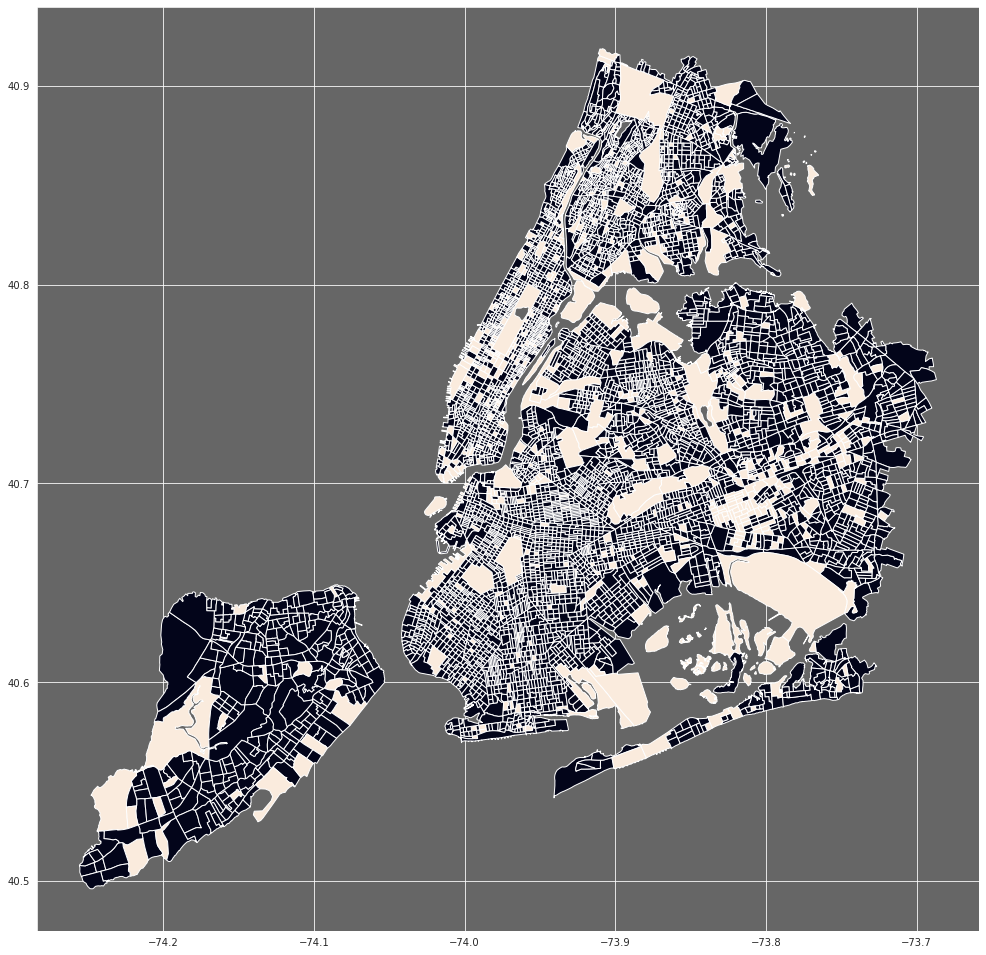

In [65]:
sns.set_style("darkgrid", {"axes.facecolor": ".4"})

col_to_draw = 'is_outlier' # col value corresponds grossfloorarea
census_gdf[['geometry', col_to_draw]].plot(figsize = (17,17), column = col_to_draw)
plt.show()

# Lets see which areas have data that is on the extremes of distribution for NYC

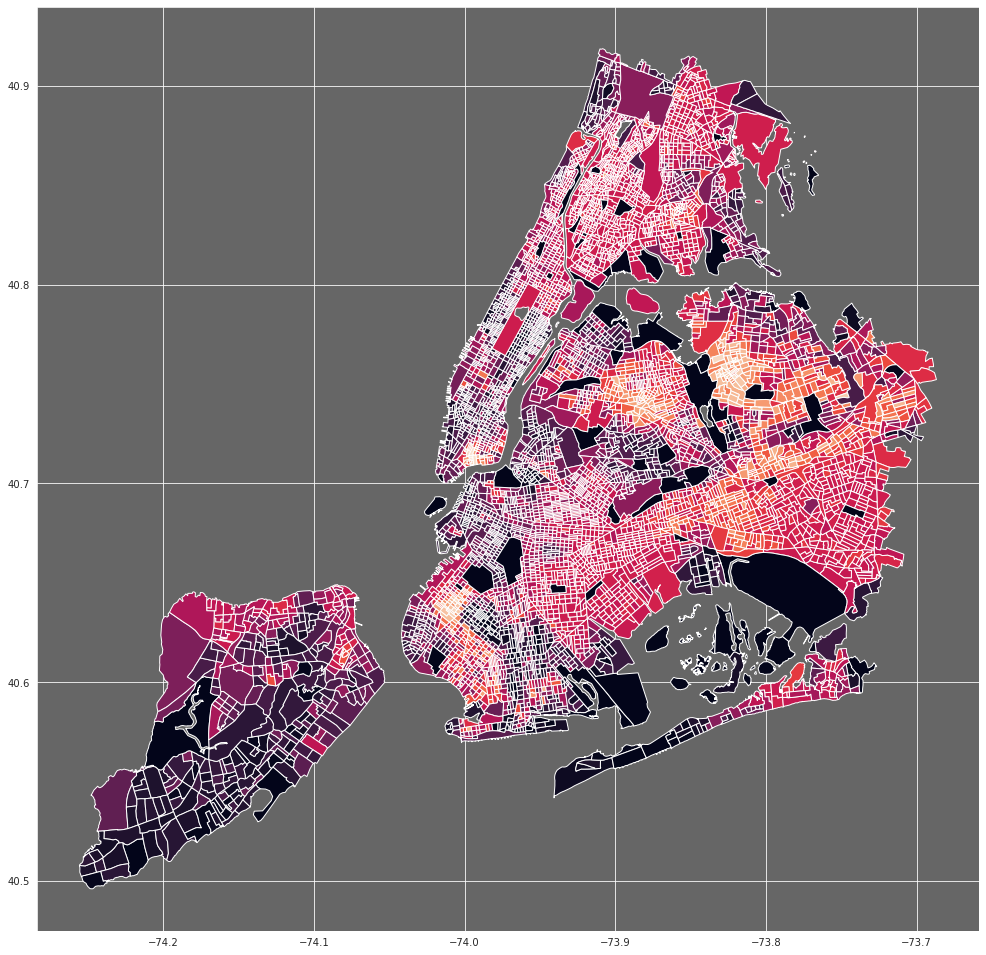

In [66]:
col_to_draw = 'perc_racial_minorities' # col value corresponds grossfloorarea
census_gdf[['geometry', col_to_draw]].plot(figsize = (17,17), column = col_to_draw)
plt.show()

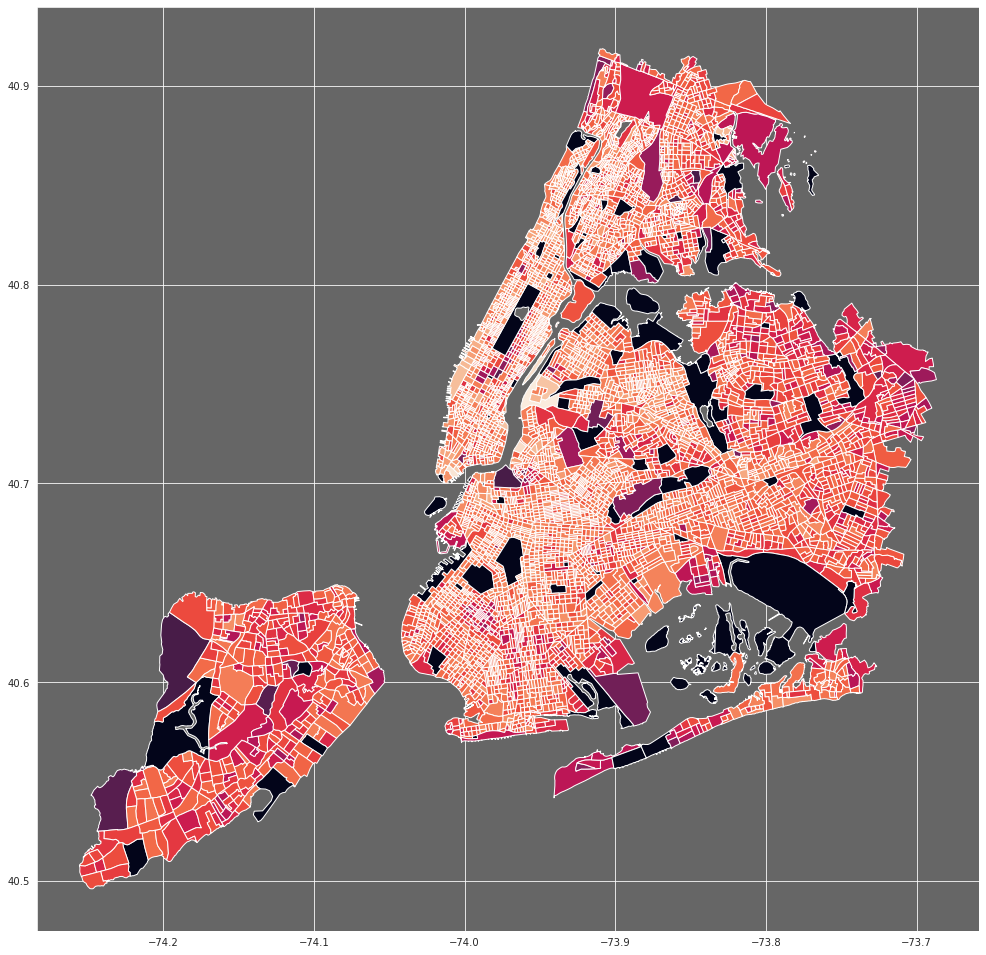

In [67]:
col_to_draw = 'log_commuters_by_public_transportation' # col value corresponds grossfloorarea
census_gdf[['geometry', col_to_draw]].plot(figsize = (17,17), column = col_to_draw)
plt.show()

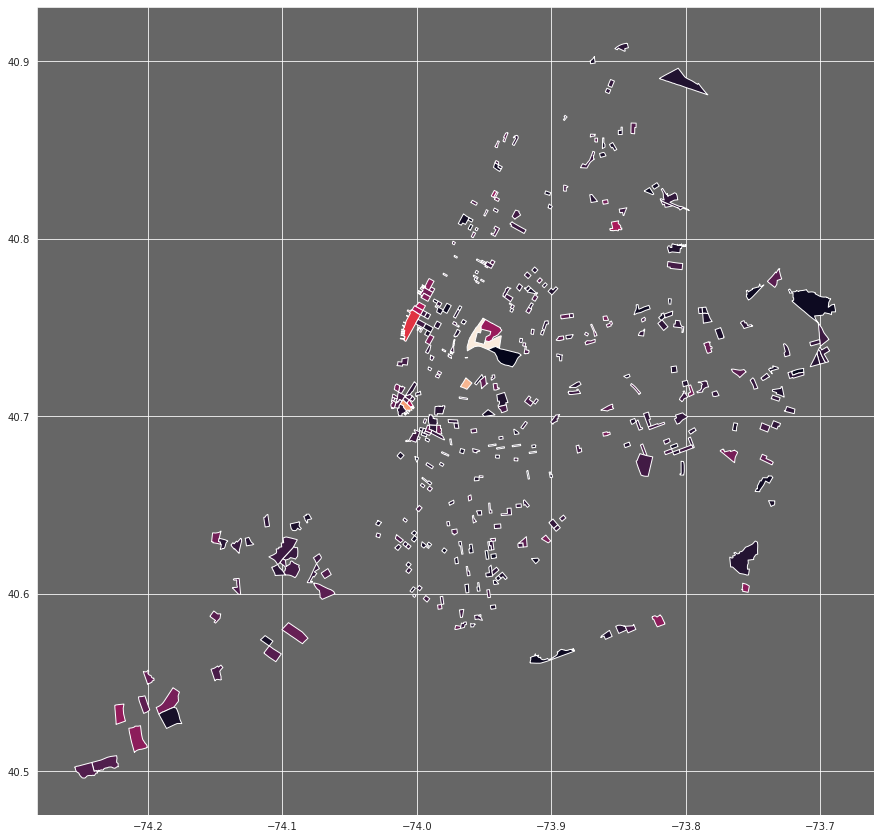

In [64]:
col_to_draw = 'aggregate_travel_time_to_work' # col value corresponds grossfloorarea
census_gdf[['geometry', col_to_draw]].plot(figsize = (17,17), column = col_to_draw)
plt.show()

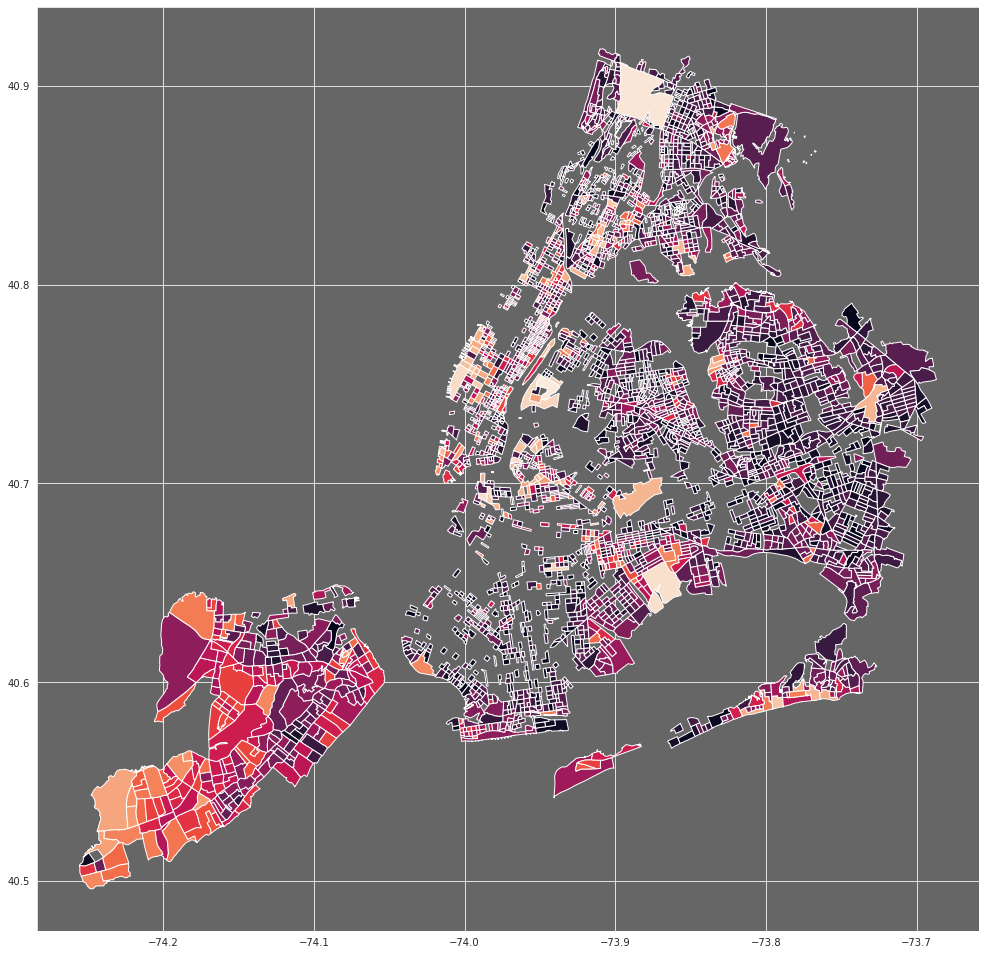

In [72]:
col_to_draw = 'median_year_structure_built' # col value corresponds grossfloorarea
filtr = census_gdf[col_to_draw] > 1800

census_gdf[filtr][['geometry', col_to_draw]].plot(figsize = (17,17), column = col_to_draw)
plt.show()

#Known values of construction year